# Future Years

In [1]:
import time

# Start the timer
start_time = time.time()


PyPSA-GB can model the GB power system  by solving a network constrained Linear Optimal Power Flow (LOPF) problem. This notebook shows the example application of a FES 2022.

In [2]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [3]:
import pypsa
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.style.use('ggplot')
import pandas as pd
import cartopy.crs as ccrs
import data_reader_writer

## Setting up simulation

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [4]:
df_network=pd.read_csv('LOPF_data_heat_2022/buses.csv')
cols=df_network.name.values[29:].tolist()
cols=['Timestamp']+cols

In [5]:
heating_EDRP=pd.read_csv('REMA/domestic_EDRP/scaled with normalised profiles/hourly heat demand total_withGasboilers_MW.csv')
heating_EDRP_DHN=pd.read_csv('REMA/domestic_EDRP_DHN/scaled with normalised profiles/hourly heat demand total_withDHN_MW.csv')
heating_RHPP=pd.read_csv('REMA/domestic_RHPP/scaled with normalised profiles/hourly heat demand total_withHPs_MW.csv')

In [6]:
heating_EDRP.columns=cols
heating_EDRP_DHN.columns=cols
heating_RHPP.columns=cols

In [7]:
total_heating_demand=heating_EDRP_DHN+heating_RHPP+heating_EDRP

In [8]:
total_heating_demand['Timestamp']=heating_EDRP['Timestamp']           # overriding the timestamp since that altered during addition

In [9]:
total_heating_demand = total_heating_demand.reset_index(drop=True)
total_heating_demand.set_index('Timestamp')

,Beauly,Peterhead,Errochty,Denny/Bonnybridge,Neilston,Strathaven,Torness,Eccles,Harker,Stella West,...,Bramford,Pelham,Sundon/East Claydon,Melksham,Bramley,London,Kemsley,Sellindge,Lovedean,S.W.Penisula
Timestamp,,,,,,,,,,,,,,,,,,,,,
01/01/2022 00:00,456.475010,684.200583,333.699659,1706.339135,2333.931472,1015.305759,1452.386874,539.267967,734.099194,3484.172054,...,2527.932125,1866.720863,3240.881007,4989.622316,3254.716135,13640.573948,2909.985945,689.302588,3573.882079,2496.302260
01/01/2022 01:00,456.475010,605.184885,333.699659,1706.339135,2333.931472,1015.305759,1386.466638,514.093547,645.125872,3072.696400,...,2230.585014,1866.720863,2853.580724,4375.302851,2862.223763,12030.932884,2909.985945,609.053071,3152.293569,1880.695084
01/01/2022 02:00,456.475010,615.022492,298.026621,1539.795064,2333.931472,1015.305759,1398.361747,518.024404,734.099194,3373.600337,...,2259.012295,1866.720863,3240.881007,4412.951641,2892.321128,12180.841344,2611.947835,617.362968,3152.293569,1880.695084
01/01/2022 03:00,480.791023,739.777076,354.689922,1829.378152,2439.869227,1162.781832,1666.992177,617.782896,776.306006,4017.758399,...,2644.150211,1866.720863,3436.320203,4412.951641,2862.223763,14497.071039,3105.942379,734.391309,3798.525369,2263.554122
01/01/2022 04:00,841.968923,1285.406287,354.689922,1829.378152,2439.869227,1162.781832,2928.045349,1087.958548,1357.944325,3072.696400,...,4667.018843,1866.720863,5989.435808,9239.573452,6018.596442,25188.212274,5365.368237,734.391309,6599.261373,3955.716362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31/12/2022 19:00,6280.158735,2507.501155,4056.329632,20410.778837,38252.428459,13705.575634,10022.135464,3730.841684,14051.119437,33196.872431,...,20611.354374,8543.771550,3240.881007,35877.876722,2892.321128,104489.472387,21165.249939,2038.736484,16144.368144,26494.989448
31/12/2022 20:00,6280.158735,5011.333393,6278.753316,31557.517998,40271.159892,14374.659405,14741.960956,5492.564099,17824.087306,54467.702325,...,2644.150211,8543.771550,17560.143002,35877.876722,2862.223763,104489.472387,2909.985945,5197.558668,16144.368144,10544.284268
31/12/2022 21:00,6280.158735,1816.081587,6278.753316,31557.517998,38252.428459,13705.575634,10022.135464,3730.841684,8253.582209,56210.059882,...,7251.149481,1866.720863,17560.143002,27942.318765,9704.299478,56086.292143,13406.656667,5434.112332,5457.549091,6712.217901


In [10]:
total_heating_demand.to_csv('LOPF_data_heat_2022/total_heating_demand.csv',index=False,header=True)

In [11]:
network = pypsa.Network()
network.import_from_csv_folder('LOPF_data_heat_2022_LimitedCentralHPs')

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network LOPF_data_heat_2022_LimitedCentralHPs has buses, generators, lines, links, loads, storage_units


In [12]:
for i in range(29):
    network.add(
        "Generator",
        "boiler {}".format(i+1),
       bus='Heat Bus {}'.format(i+1),
       p_nom_extendable=True,
        ramp_limit_up=1,
        ramp_limit_down=1,
        efficiency=0.80,
        marginal_cost=20.0,
        carrier="heat",
    )

Links need to be scaled up to accomadate for future generation.

In [13]:
contingency_factor = 0.7
network.lines.s_max_pu *= contingency_factor

In [14]:
network.generators

,carrier,type,p_nom,bus,marginal_cost,ramp_limit_up,ramp_limit_down,p_max_pu,control,p_nom_extendable,...,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
Drax - coal units,Coal,Conventional steam,1320.000000,Thornton/Drax/Eggborough,NaN,1.00,1.00,1.00,PQ,False,...,False,0.0,0.0,0,0,1,0,1.0,1.0,0.0
West Burton,Coal,Conventional steam,2000.000000,Keadby,NaN,1.00,1.00,1.00,PQ,False,...,False,0.0,0.0,0,0,1,0,1.0,1.0,0.0
Ratcliffe,Coal,Conventional steam,2021.000000,Ratcliffe,NaN,1.00,1.00,1.00,PQ,False,...,False,0.0,0.0,0,0,1,0,1.0,1.0,0.0
Hartlepool,Nuclear,AGR,1012.327373,Stella West,5.0,0.03,0.03,0.73,PQ,False,...,False,0.0,0.0,0,0,1,0,1.0,1.0,0.0
Heysham 1,Nuclear,AGR,905.541785,Penwortham,5.0,0.03,0.03,0.73,PQ,False,...,False,0.0,0.0,0,0,1,0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
boiler 25,heat,,0.000000,Heat Bus 25,20.0,1.00,1.00,1.00,PQ,True,...,False,0.0,0.0,0,0,1,0,1.0,1.0,0.0
boiler 26,heat,,0.000000,Heat Bus 26,20.0,1.00,1.00,1.00,PQ,True,...,False,0.0,0.0,0,0,1,0,1.0,1.0,0.0
boiler 27,heat,,0.000000,Heat Bus 27,20.0,1.00,1.00,1.00,PQ,True,...,False,0.0,0.0,0,0,1,0,1.0,1.0,0.0


In [15]:
network.consistency_check()

In [16]:
network.generators_t.p_max_pu

Generator,Wind Offshore Keadby,Wind Offshore Stella West,Wind Offshore Penwortham,Wind Offshore Neilston,Wind Offshore Torness,Wind Offshore Bramford,Wind Offshore Peterhead,Wind Offshore Deeside,Wind Offshore Walpole,Wind Offshore Kemsley,...,Tidal lagoon S.W.Penisula,Tidal lagoon Deeside,Tidal lagoon Melksham,Tidal stream S.W.Penisula,Tidal stream Neilston,Tidal stream Peterhead,Tidal stream Deeside,Tidal stream Lovedean,Tidal stream Beauly,Wave power Beauly
snapshot,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,1.000000,0.995117,0.999829,1.0,1.000000,0.995777,0.903791,0.986240,0.999883,0.996920,...,0.000000,0.000000,0.000000,0.384986,0.528102,0.000000,0.384986,0.222793,0.000000,0.34667
2022-01-01 01:00:00,1.000000,0.997188,1.000000,1.0,1.000000,0.997815,0.910892,0.999388,1.000000,0.997603,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.384986,0.803177,0.803177,0.222793,0.34667
2022-01-01 02:00:00,1.000000,0.999701,1.000000,1.0,1.000000,0.999426,0.934952,0.999997,1.000000,0.996054,...,0.000000,0.000000,0.026342,0.912560,1.000000,1.000000,0.611344,1.000000,1.000000,0.45200
2022-01-01 03:00:00,1.000000,0.999977,1.000000,1.0,1.000000,0.999200,0.974837,1.000000,1.000000,0.988015,...,0.000000,0.000000,0.000000,0.270388,1.000000,1.000000,0.270388,0.803177,1.000000,0.45200
2022-01-01 04:00:00,1.000000,1.000000,1.000000,1.0,1.000000,0.997808,0.964442,0.999939,1.000000,0.977303,...,0.000000,0.806250,0.000000,0.000000,0.222793,0.803177,0.000000,0.270388,1.000000,0.45200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.997458,0.896438,0.991397,1.0,0.795113,0.999893,0.957313,0.957472,0.997273,1.000000,...,0.683500,0.226778,0.460159,0.066013,0.114070,1.000000,0.000000,0.181139,1.000000,0.25067
2022-12-31 20:00:00,0.859724,0.884008,0.999465,1.0,0.816021,0.999025,0.964889,0.971011,0.862633,0.987612,...,0.169917,0.000000,0.376467,0.000000,0.000000,0.324320,0.000000,0.000000,0.181139,0.25067
2022-12-31 21:00:00,0.621725,0.903212,0.999965,1.0,0.893784,0.989160,0.969399,0.989499,0.614079,0.897459,...,0.000000,0.000000,0.008374,0.270388,0.528102,0.000000,0.270388,0.087863,0.000000,0.34667


In [17]:
#network.model
Linopy_model=network.optimize.create_model()

C:\Users\salene\Anaconda3\envs\PyPSA-GB\lib\site-packages\linopy\model.py:607: UserWarning: Reindexing constraint `Generator-fix-p-ramp_limit_up` to match existing coordinates.
  warnings.warn(
C:\Users\salene\Anaconda3\envs\PyPSA-GB\lib\site-packages\linopy\model.py:607: UserWarning: Reindexing constraint `Generator-fix-p-ramp_limit_down` to match existing coordinates.
  warnings.warn(
C:\Users\salene\Anaconda3\envs\PyPSA-GB\lib\site-packages\linopy\model.py:607: UserWarning: Reindexing constraint `Generator-ext-p-ramp_limit_up` to match existing coordinates.
  warnings.warn(
C:\Users\salene\Anaconda3\envs\PyPSA-GB\lib\site-packages\linopy\model.py:607: UserWarning: Reindexing constraint `Generator-ext-p-ramp_limit_down` to match existing coordinates.
  warnings.warn(
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [18]:
network.optimize(solver_name='gurobi')

C:\Users\salene\Anaconda3\envs\PyPSA-GB\lib\site-packages\linopy\model.py:607: UserWarning: Reindexing constraint `Generator-fix-p-ramp_limit_up` to match existing coordinates.
  warnings.warn(
C:\Users\salene\Anaconda3\envs\PyPSA-GB\lib\site-packages\linopy\model.py:607: UserWarning: Reindexing constraint `Generator-fix-p-ramp_limit_down` to match existing coordinates.
  warnings.warn(
C:\Users\salene\Anaconda3\envs\PyPSA-GB\lib\site-packages\linopy\model.py:607: UserWarning: Reindexing constraint `Generator-ext-p-ramp_limit_up` to match existing coordinates.
  warnings.warn(
C:\Users\salene\Anaconda3\envs\PyPSA-GB\lib\site-packages\linopy\model.py:607: UserWarning: Reindexing constraint `Generator-ext-p-ramp_limit_down` to match existing coordinates.
  warnings.warn(
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO:linopy.model: Solve linear problem using Gu

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-29


Read LP format model from file C:\Users\salene\AppData\Local\Temp\linopy-problem-3k0ta65t.lp
Reading time = 113.31 seconds
obj: 28696894 rows, 9084179 columns, 51717043 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 28696894 rows, 9084179 columns and 51717043 nonzeros
Model fingerprint: 0xff242155
Coefficient statistics:
  Matrix range     [6e-05, 3e+03]
  Objective range  [1e+00, 1e+09]
  Bounds range     [1e+07, 1e+07]
  RHS range        [2e-07, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 25376868 rows and 30 columns (presolve time = 7s) ...
Presolve removed 25376868 rows and 1116347 columns (presolve time = 12s) ...
Presolve removed 25376868 rows and 1116347 columns (presolve time = 

  81   1.10185752e+11  1.10101286e+11  7.40e-04 7.15e-07  7.26e+00  1386s
  82   1.10180078e+11  1.10103051e+11  6.86e-04 4.77e-07  6.62e+00  1400s
  83   1.10177475e+11  1.10104506e+11  6.61e-04 7.15e-07  6.27e+00  1414s
  84   1.10172788e+11  1.10106128e+11  6.14e-04 7.15e-07  5.73e+00  1428s
  85   1.10170382e+11  1.10107830e+11  5.91e-04 7.15e-07  5.38e+00  1442s
  86   1.10169558e+11  1.10108071e+11  5.80e-04 7.15e-07  5.28e+00  1455s
  87   1.10167096e+11  1.10110648e+11  5.47e-04 7.15e-07  4.85e+00  1469s
  88   1.10164016e+11  1.10111491e+11  5.13e-04 7.15e-07  4.51e+00  1483s
  89   1.10162248e+11  1.10113182e+11  4.94e-04 7.15e-07  4.22e+00  1497s
  90   1.10161117e+11  1.10113743e+11  4.78e-04 7.15e-07  4.07e+00  1508s
  91   1.10159456e+11  1.10114449e+11  4.56e-04 7.15e-07  3.87e+00  1521s
  92   1.10156556e+11  1.10114901e+11  4.21e-04 7.15e-07  3.58e+00  1535s
  93   1.10154821e+11  1.10115878e+11  4.01e-04 7.15e-07  3.35e+00  1549s
  94   1.10153199e+11  1.10116246e+11 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 9084179 primals, 28696894 duals
Objective: 1.10e+11
Solver model: available
Solver message: 2



('ok', 'optimal')

In [19]:
Linopy_model

Linopy model

Variables:
----------
Dimensions:                      (Generator-ext: 29, StorageUnit-ext: 29,
                                  snapshot: 8760, Generator: 462, Line: 99,
                                  Link: 29, StorageUnit: 149)
Coordinates:
  * Generator-ext                (Generator-ext) object 'boiler 1' ... 'boile...
  * StorageUnit-ext              (StorageUnit-ext) object 'STES_Beauly' ... '...
  * snapshot                     (snapshot) datetime64[ns] 2022-01-01 ... 202...
  * Generator                    (Generator) object 'Drax - coal units' ... '...
  * Line                         (Line) object '0' '1' '2' ... '96' '97' '98'
  * Link                         (Link) object 'heat pump Beauly' ... 'heat p...
  * StorageUnit                  (StorageUnit) object 'Dinorwig' ... 'STES_S_...
Data:
    Generator-p_nom              (Generator-ext) int32 0 1 2 3 4 ... 25 26 27 28
    StorageUnit-p_nom            (StorageUnit-ext) int32 29 30 31 ... 55 56 57
    Gener

In [20]:

#def remove_kvl(network, sns):
    #print("KVL removed!")
    #network.model.constraints.remove("Kirchhoff-Voltage-Law")

#network.optimize(solver_name='gurobi',extra_functionality=remove_kvl)

The return value of the add_constraints function is a array with the labels of the constraints. We can access the constraint now through:

In [21]:
#Linopy_model.constraints['StorageUnit_minimum_soc']

In [22]:
# let us check and Analyse the constraints, we set afer the network created
network.storage_units_t.state_of_charge

StorageUnit,Dinorwig,Ffestiniog,Cruachan,Foyers,Beauly Battery,Peterhead Battery,Errochty Battery,Denny/Bonnybridge Battery,Neilston Battery,Strathaven Battery,...,STES_Bramford,STES_Pelham,STES_Sundon_East_Claydon,STES_Melksham,STES_Bramley,STES_London,STES_Kemsley,STES_Sellindge,STES_Lovedean,STES_S_W_Penisula
snapshot,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,8315.651565,1279.417052,7830.773160,6861.268301,86.784654,86.784654,13.909397,13.909397,86.784654,13.909397,...,1.438675e+06,1.438832e+06,1.437174e+06,1.438934e+06,1.439474e+06,1.437445e+06,1.439474e+06,1.439474e+06,1.439474e+06,1.439474e+06
2022-01-01 01:00:00,8315.651565,1279.417052,7830.773160,6773.947492,79.679317,86.784654,13.909397,13.909397,86.784654,13.909397,...,1.293483e+06,1.293781e+06,1.290631e+06,1.293975e+06,1.295000e+06,1.291145e+06,1.295000e+06,1.295000e+06,1.295000e+06,1.295000e+06
2022-01-01 02:00:00,8315.651565,1279.417052,7830.773160,6686.626682,72.573979,86.784654,13.909397,13.909397,86.784654,0.000000,...,1.162810e+06,1.163235e+06,1.158743e+06,1.163512e+06,1.164974e+06,1.159476e+06,1.164974e+06,1.164974e+06,1.164974e+06,1.164974e+06
2022-01-01 03:00:00,8315.651565,1279.417052,7830.773160,6599.305873,65.468642,86.784654,21.014735,56.355087,86.784654,21.014735,...,1.045204e+06,1.045744e+06,1.040043e+06,1.046095e+06,1.047951e+06,1.040973e+06,1.047951e+06,1.047951e+06,1.047951e+06,1.047951e+06
2022-01-01 04:00:00,8315.651565,1279.417052,7830.773161,6358.110219,7.105338,86.784654,86.784654,86.784654,86.784654,86.784654,...,9.393592e+05,9.400016e+05,9.332129e+05,9.404192e+05,9.426295e+05,9.343204e+05,9.426295e+05,9.426295e+05,9.426295e+05,9.426295e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.000000,0.000000,817.303377,6498.674804,44.152629,0.000000,0.000000,13.909397,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2022-12-31 20:00:00,0.000000,0.000000,530.754428,6411.353995,37.047291,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2022-12-31 21:00:00,0.000000,0.000000,350.343089,6597.414932,29.941954,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


Let us see which dual values were parsed. Therfore we have a look into network.model.dual

In [23]:
network.model.dual

<xarray.Dataset>
Dimensions:                                (Generator-ext: 29,
                                            StorageUnit-ext: 29,
                                            snapshot: 8760, Generator-fix: 433,
                                            Line-fix: 99, Link-fix: 29,
                                            StorageUnit-fix: 120, Bus: 34,
                                            Bus-meshed: 24, cycles: 71,
                                            StorageUnit: 149)
Coordinates:
  * Generator-ext                          (Generator-ext) object 'boiler 1' ...
  * StorageUnit-ext                        (StorageUnit-ext) object 'STES_Bea...
  * snapshot                               (snapshot) datetime64[ns] 2022-01-...
  * Generator-fix                          (Generator-fix) object 'Drax - coa...
  * Line-fix                               (Line-fix) object '0' '1' ... '98'
  * Link-fix                               (Link-fix) object 'heat pump Beaul...
  * StorageUnit-fix                        (StorageUnit-fix) object 'Dinorwig...
  * Bus                                    (Bus) object 'Eccles' ... 'Torness'
  * Bus-meshed                             (Bus-meshed) object 'Keadby' ... '...
  * cycles                                 (cycles) int32 0 1 2 3 ... 68 69 70
  * StorageUnit                            (StorageUnit) object 'Dinorwig' .....
Data variables: (12/32)
    Generator-ext-p_nom-lower              (Generator-ext) float64 0.0 ... 0.0
    Generator-ext-p_nom-upper              (Generator-ext) float64 nan ... nan
    StorageUnit-ext-p_nom-lower            (StorageUnit-ext) float64 0.0 ... 0.0
    StorageUnit-ext-p_nom-upper            (StorageUnit-ext) float64 nan ... nan
    Generator-fix-p-lower                  (snapshot, Generator-fix) float64 ...
    Generator-fix-p-upper                  (snapshot, Generator-fix) float64 ...
    ...                                     ...
    StorageUnit-ext-state_of_charge-lower  (snapshot, StorageUnit-ext) float64 ...
    StorageUnit-ext-state_of_charge-upper  (snapshot, StorageUnit-ext) float64 ...
    Bus-nodal_balance                      (Bus, snapshot) float64 40.78 ... ...
    Bus-meshed-nodal_balance               (Bus-meshed, snapshot) float64 60....
    Kirchhoff-Voltage-Law                  (snapshot, cycles) float64 -66.66 ...
    StorageUnit-energy-balance             (snapshot, StorageUnit) float64 68...

In [24]:
#network.optimize.solve_model()

## Running the optimisation

In [25]:
#network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)
#network.optimize(solver_name='gurobi')  # 

In [26]:
network.generators.p_nom_opt.div(1e3) # GW  optimised capacity of generators in GW
network.storage_units.p_nom_opt.div(1e3)  # GW 
#My_network.links_t.efficiency 
network.storage_units

,p_nom,carrier,marginal_cost,max_hours,efficiency_store,efficiency_dispatch,state_of_charge_initial,bus,standing_loss,capital_cost,...,q_set,sign,build_year,lifetime,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
Dinorwig,1431.724138,Pumped Storage Hydroelectric,0.0,5.808138,0.865,0.865,8.315652e+03,Deeside,0.0,0.0,...,0.0,1.0,0,inf,False,NaN,False,True,0.0,1431.724138
Ffestiniog,298.275862,Pumped Storage Hydroelectric,0.0,4.289375,0.850,0.850,1.279417e+03,Deeside,0.0,0.0,...,0.0,1.0,0,inf,False,NaN,False,True,0.0,298.275862
Cruachan,440.000000,Pumped Storage Hydroelectric,0.0,17.797212,0.865,0.865,7.830773e+03,Errochty,0.0,0.0,...,0.0,1.0,0,inf,False,NaN,False,True,0.0,440.000000
Foyers,300.000000,Pumped Storage Hydroelectric,0.0,23.161964,0.865,0.865,6.948589e+03,Beauly,0.0,0.0,...,0.0,1.0,0,inf,False,NaN,False,True,0.0,300.000000
Beauly Battery,69.231494,Battery,0.0,1.253543,0.950,0.950,8.678465e+01,Beauly,0.0,0.0,...,0.0,1.0,0,inf,False,NaN,False,True,0.0,69.231494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STES_London,504.000000,Seasonal Thermal Energy Storage,0.0,2880.000000,0.900,0.950,1.440000e+06,Heat Bus 25,0.1,1000.0,...,0.0,1.0,0,inf,False,NaN,False,True,0.0,2427.393887
STES_Kemsley,505.000000,Seasonal Thermal Energy Storage,0.0,2880.000000,0.900,0.950,1.440000e+06,Heat Bus 26,0.1,1000.0,...,0.0,1.0,0,inf,False,NaN,False,True,0.0,499.817318
STES_Sellindge,506.000000,Seasonal Thermal Energy Storage,0.0,2880.000000,0.900,0.950,1.440000e+06,Heat Bus 27,0.1,1000.0,...,0.0,1.0,0,inf,False,NaN,False,True,0.0,499.817318


In [27]:
network.storage_units.index[120:150]
#network.storage_units.p_nom_opt[4:33].div(1e3).values

Index(['STES_Beauly', 'STES_Peterhead', 'STES_Errochty',
       'STES_Denny/BonnyBdige', 'STES_Neilston', 'STES_Strathaven',
       'STES_Torness', 'STES_Eccles', 'STES_Harker', 'STES_Stella West',
       'STES_Penwortham', 'STES_Deeside', 'STES_Daines',
       'STES_Marsh_Stocksbridge', 'STES_Thornton_Drax_Eggborough',
       'STES_Keadby', 'STES_Ratcliffe', 'STES_Feckenham', 'STES_Walpole',
       'STES_Bramford', 'STES_Pelham', 'STES_Sundon_East_Claydon',
       'STES_Melksham', 'STES_Bramley', 'STES_London', 'STES_Kemsley',
       'STES_Sellindge', 'STES_Lovedean', 'STES_S_W_Penisula'],
      dtype='object', name='StorageUnit')

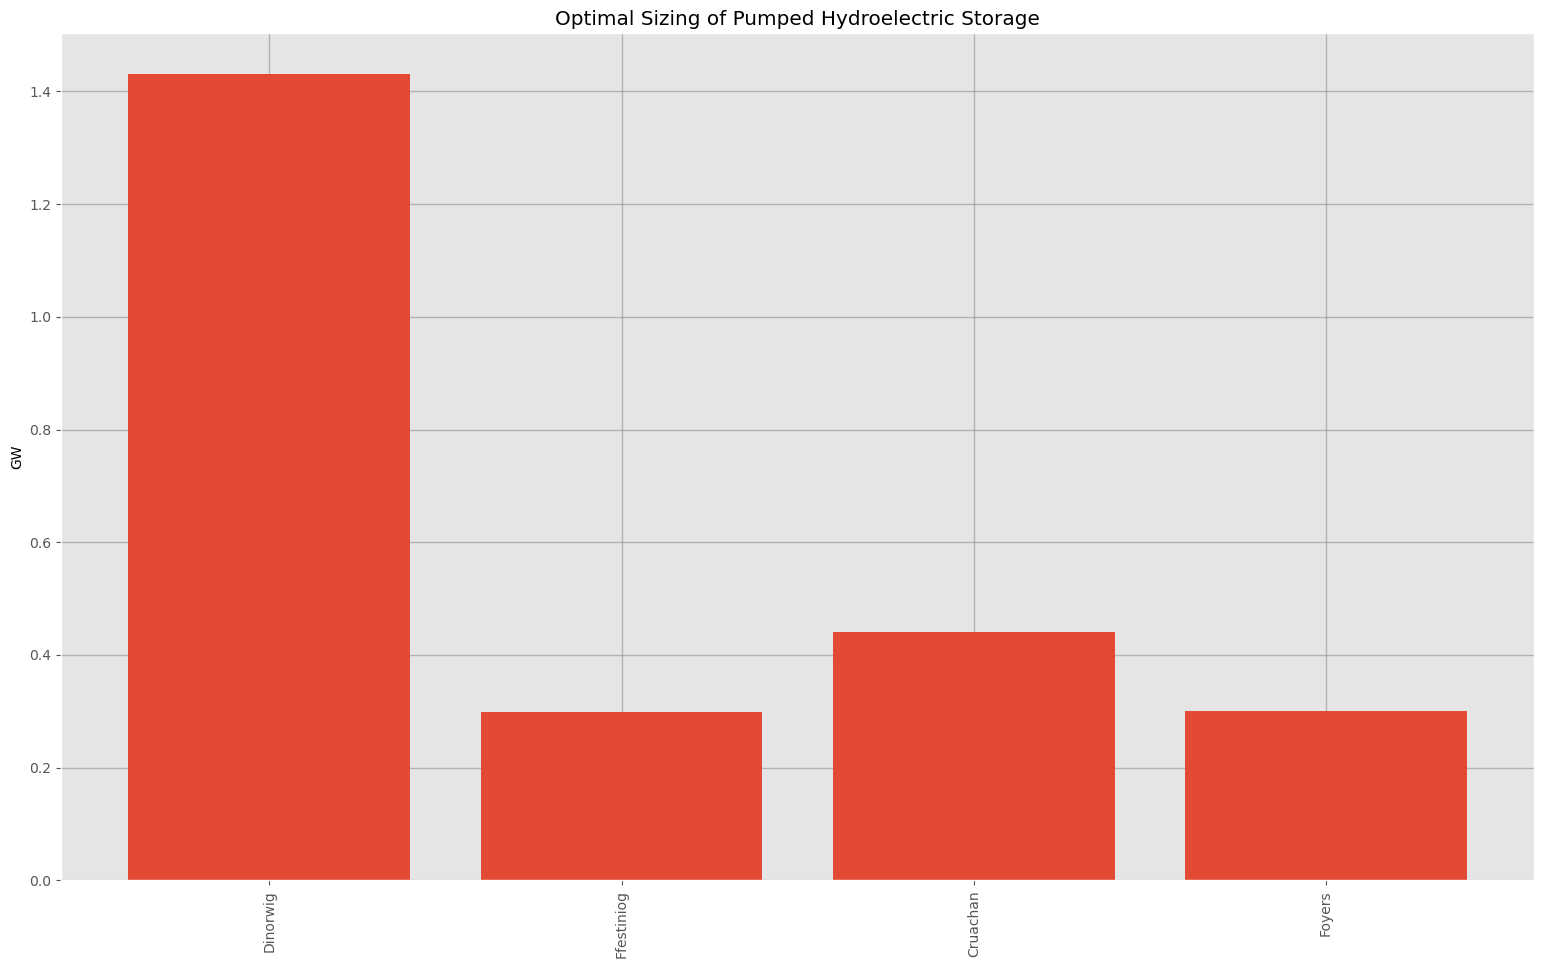

In [28]:
plt.figure(figsize=(19,11))
plt.bar(network.storage_units.index[:4], network.storage_units.p_nom_opt[:4].div(1e3).values)

plt.xticks(network.storage_units.index[:4], rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('Optimal Sizing of Pumped Hydroelectric Storage')
plt.show()

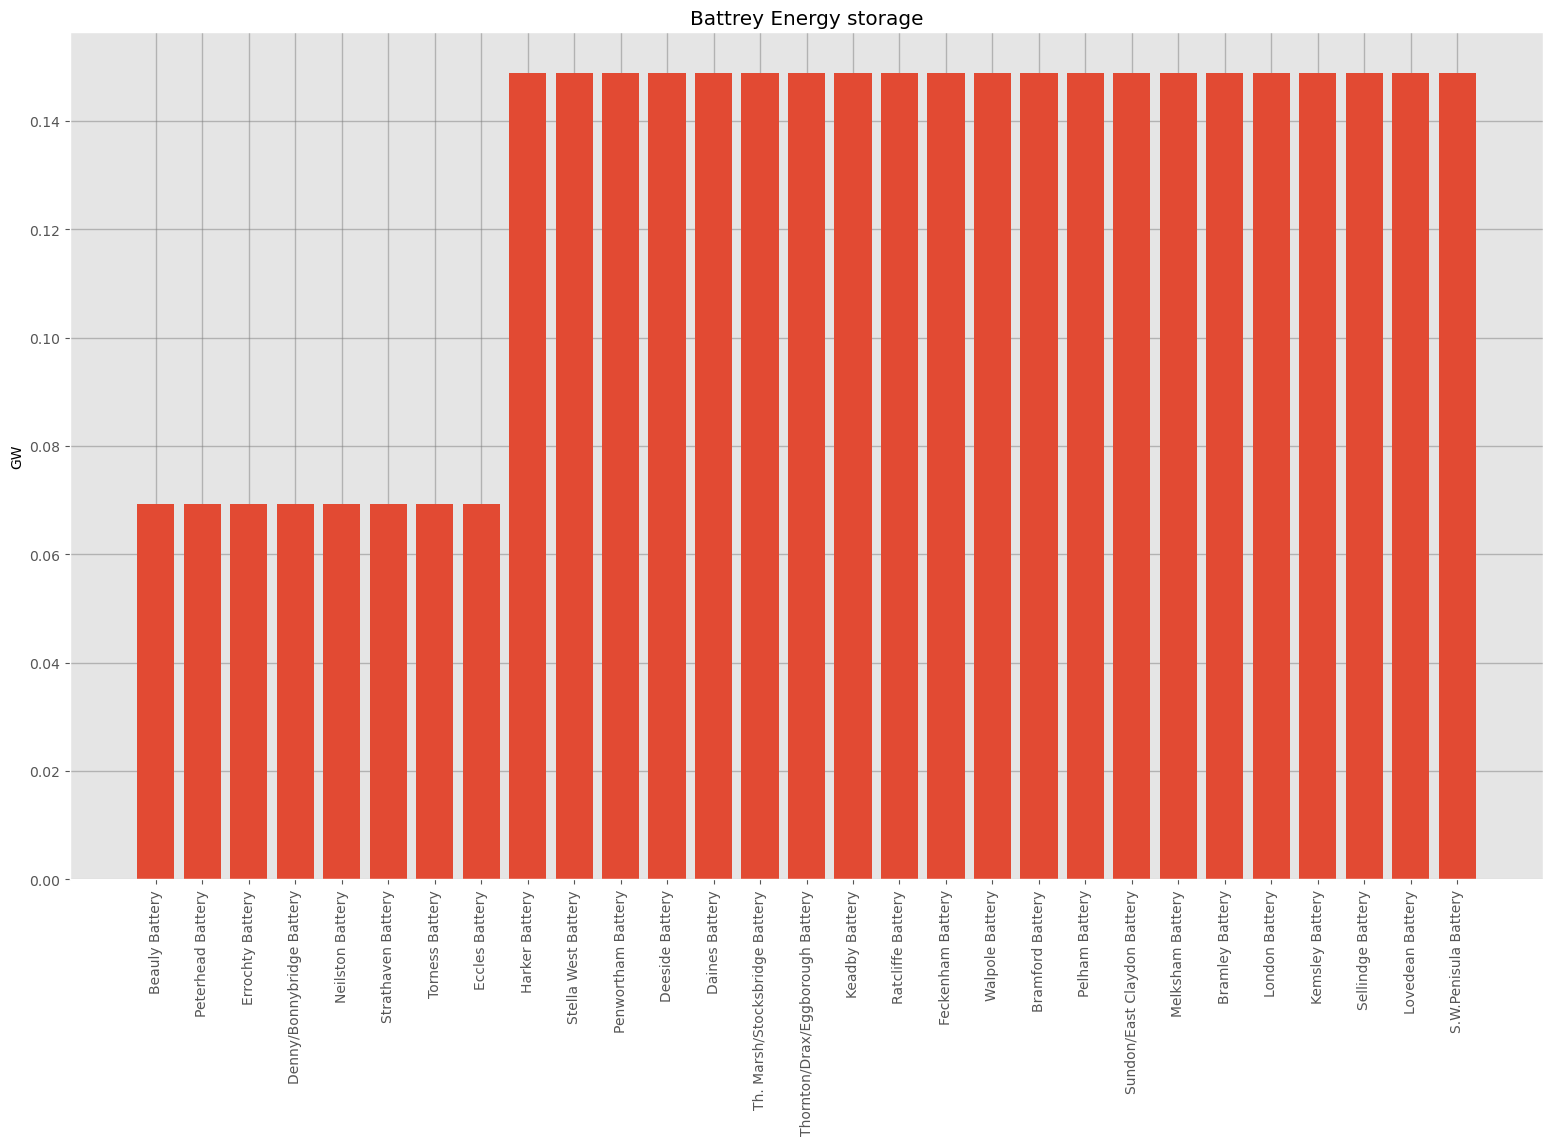

In [29]:
plt.figure(figsize=(19,11))
plt.bar(network.storage_units.index[4:33], network.storage_units.p_nom_opt[4:33].div(1e3).values)

plt.xticks(network.storage_units.index[4:33], rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('Battrey Energy storage')
plt.show()

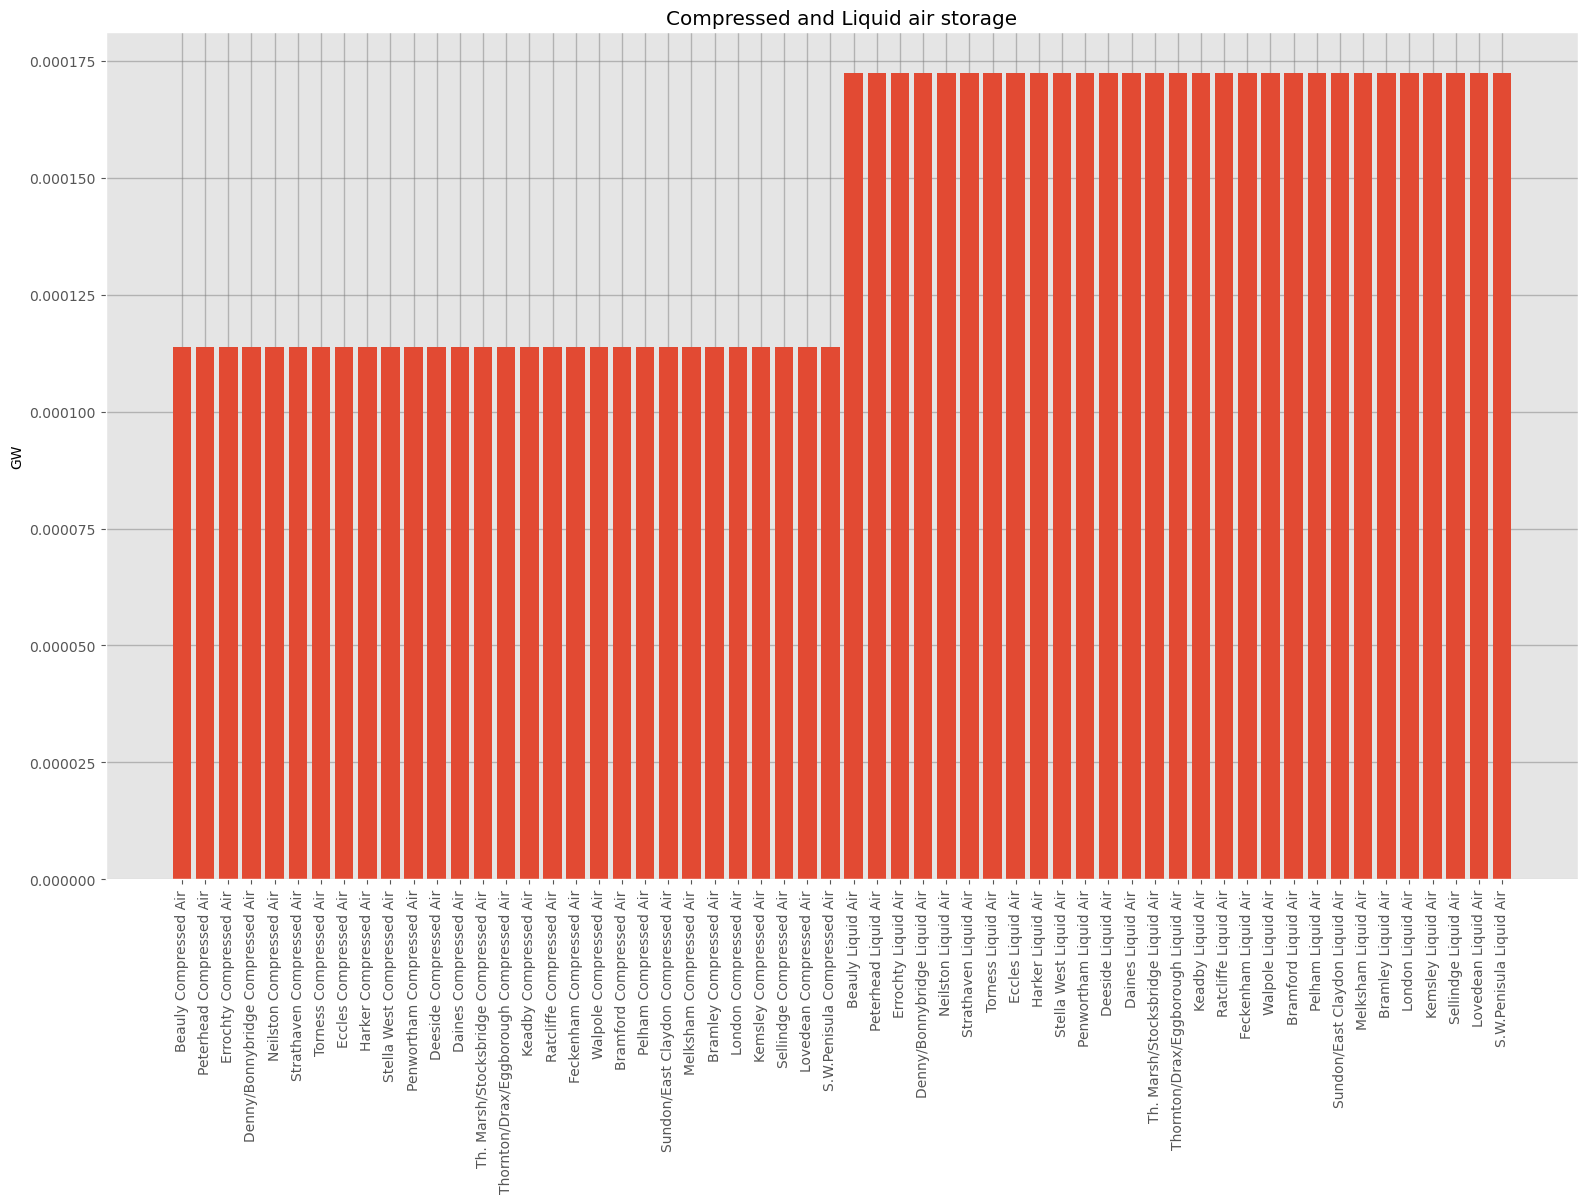

In [30]:
plt.figure(figsize=(19,11))
plt.bar(network.storage_units.index[33:91], network.storage_units.p_nom_opt[33:91].div(1e3).values)

plt.xticks(network.storage_units.index[33:91], rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('Compressed and Liquid air storage')
plt.show()

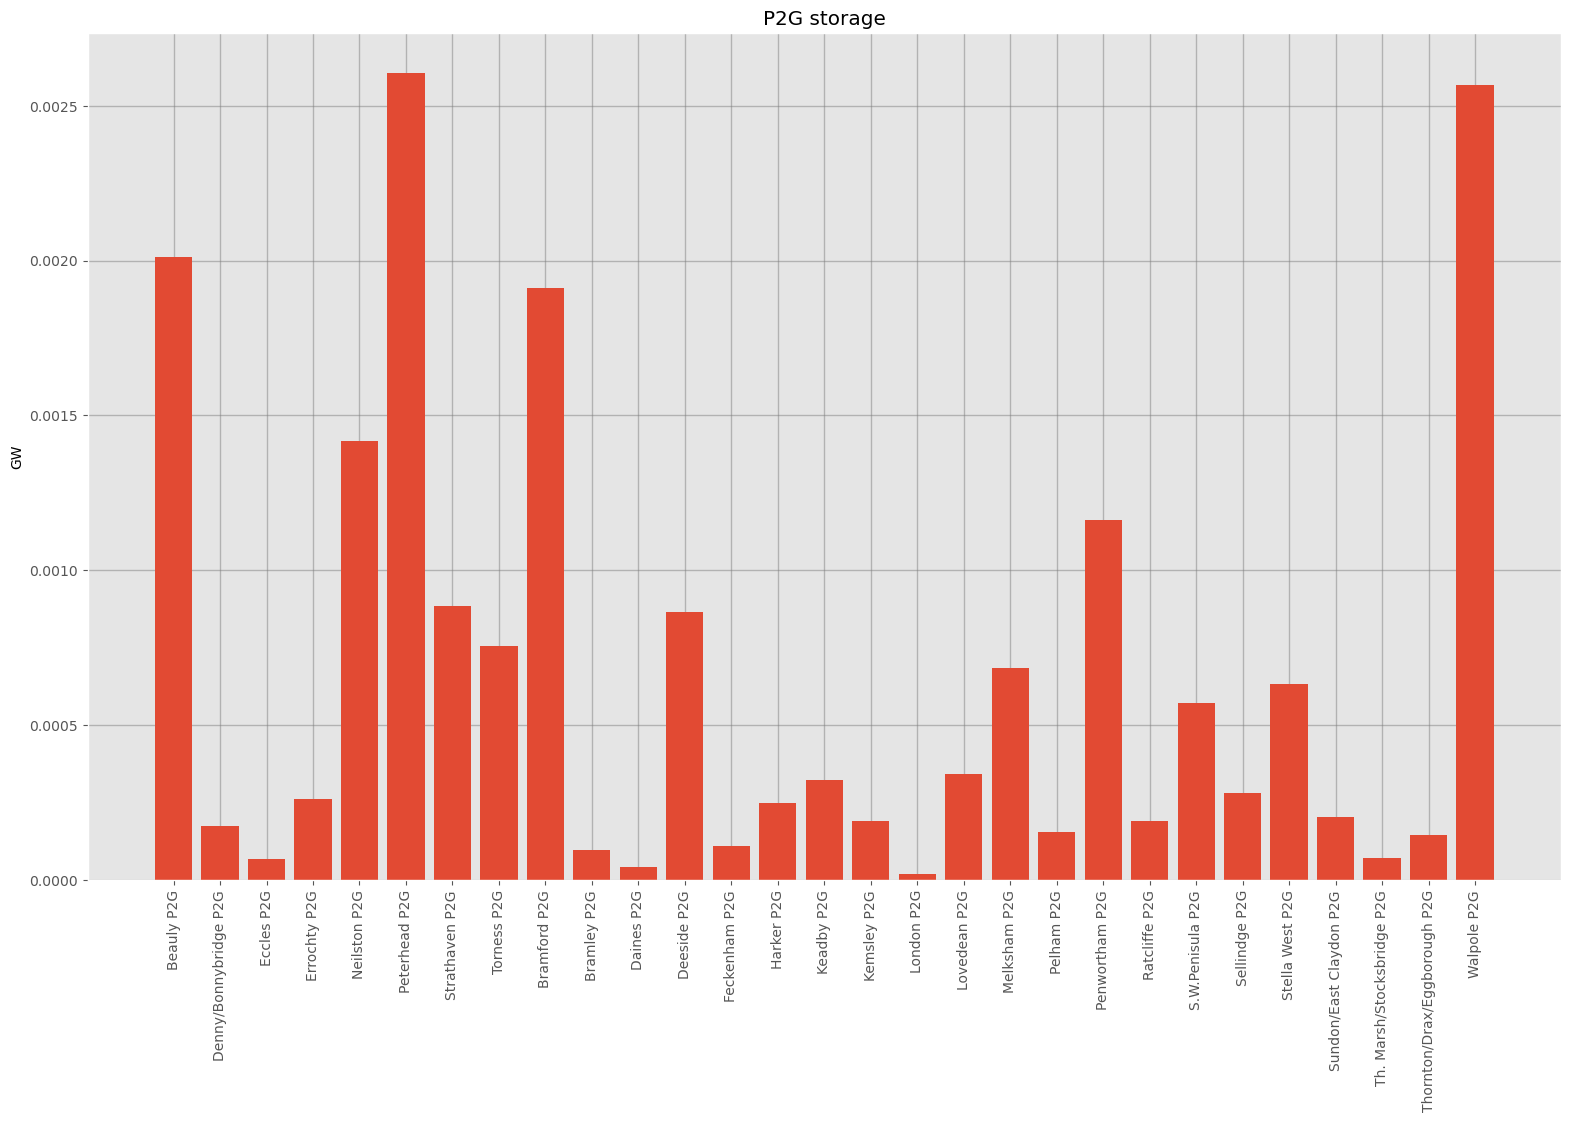

In [31]:
plt.figure(figsize=(19,11))
plt.bar(network.storage_units.index[91:120], network.storage_units.p_nom_opt[91:120].div(1e3).values)

plt.xticks(network.storage_units.index[91:120], rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('P2G storage')
plt.show()

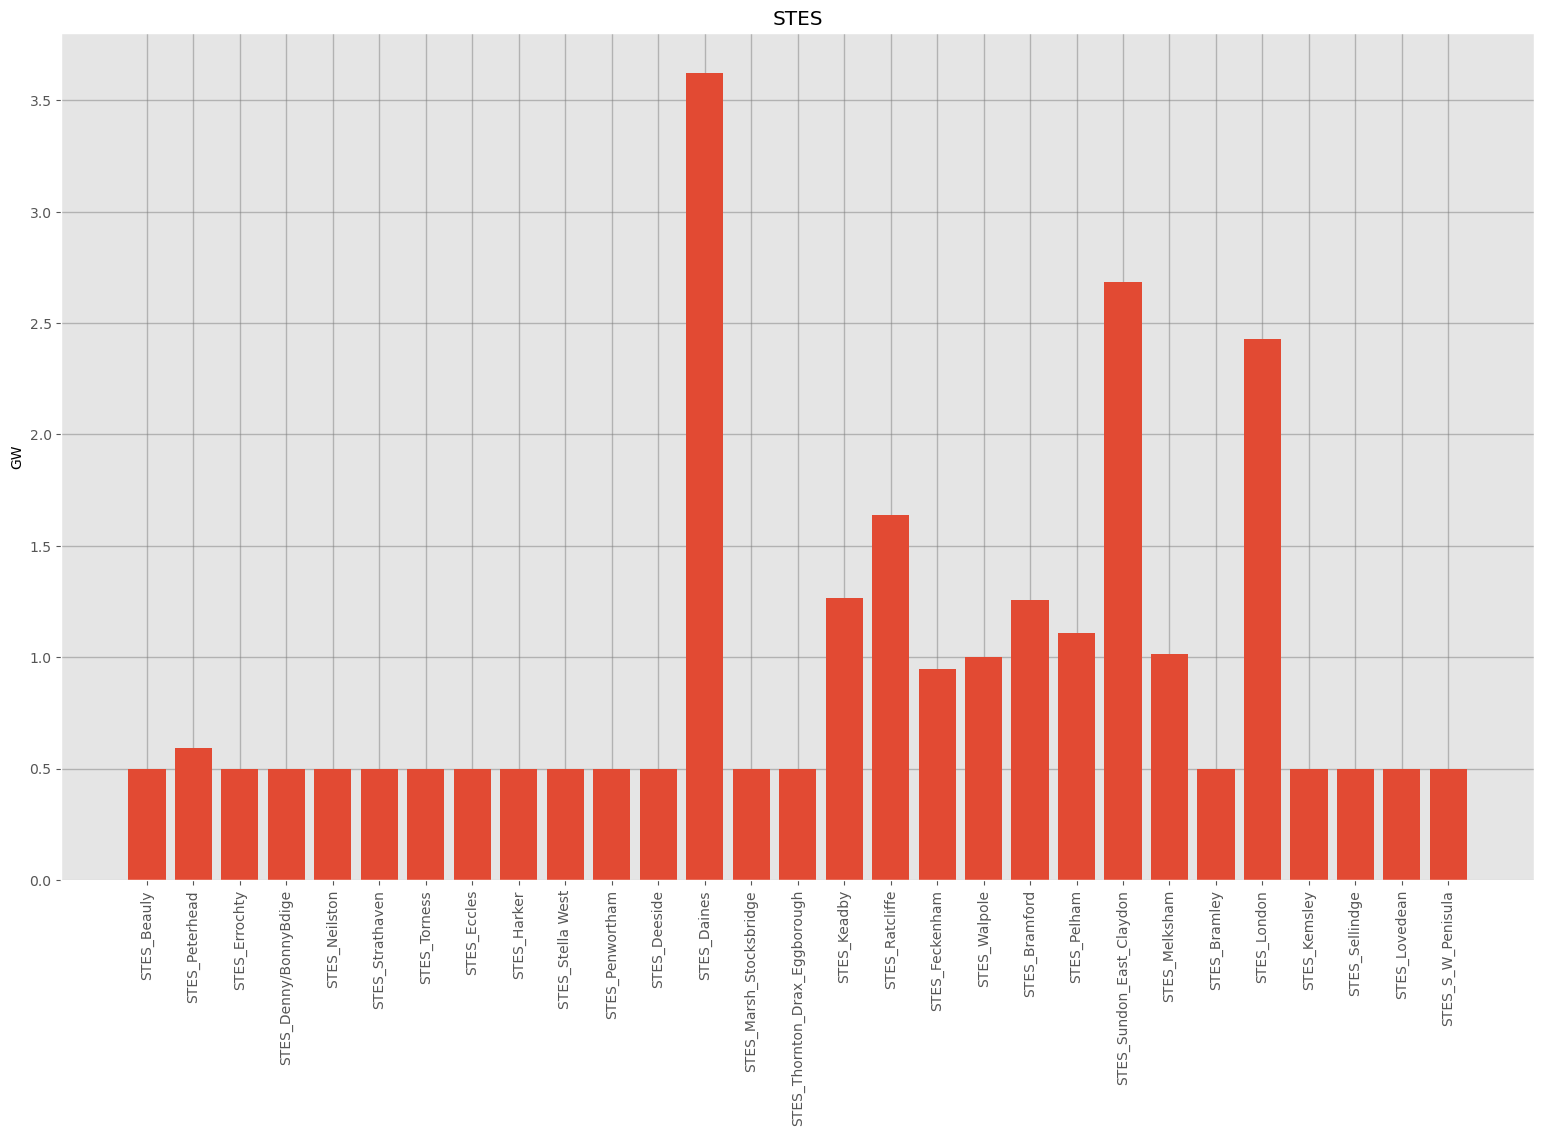

In [32]:
plt.figure(figsize=(19,11))
plt.bar(network.storage_units.index[120:150], network.storage_units.p_nom_opt[120:150].div(1e3).values)

plt.xticks(network.storage_units.index[120:150], rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('STES')
plt.show()

## Power output by generation type

Group the generators by the carrier, and print their summed power outputs over the simulation period.

In [33]:
year=2022

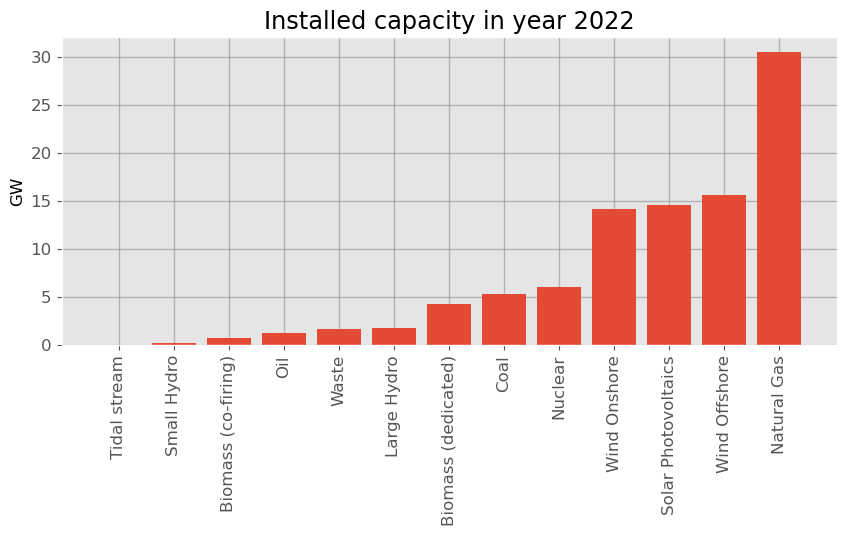

In [34]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

#imp = network.links_t.p0.copy()
#imp[imp < 0] = 0
#imp['Interconnectors Import'] = imp.sum(axis=1)
#interconnector_import = imp[['Interconnectors Import']]

#p_by_carrier = pd.concat([p_by_carrier, interconnector_import], axis=1)

#exp = network.links_t.p0.copy()
#exp[exp > 0] = 0
#exp['Interconnectors Export'] = exp.sum(axis=1)
#interconnector_export = exp[['Interconnectors Export']]

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

generators_p_nom = network.generators.p_nom.groupby(
    network.generators.carrier).sum().sort_values()
if year > 2020:
    generators_p_nom.drop('Unmet Load', inplace=True)
generators_p_nom.drop(generators_p_nom[generators_p_nom < 50].index, inplace=True)

plt.rcParams.update({'font.size': 12})
# bar chart
plt.figure(figsize=(10,4))
plt.bar(generators_p_nom.index, generators_p_nom.values / 1000)
plt.xticks(generators_p_nom.index, rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('Installed capacity in year ' + str(year))
plt.show()

Graph the power output of the different generation types...

Text(0.5, 0, '')

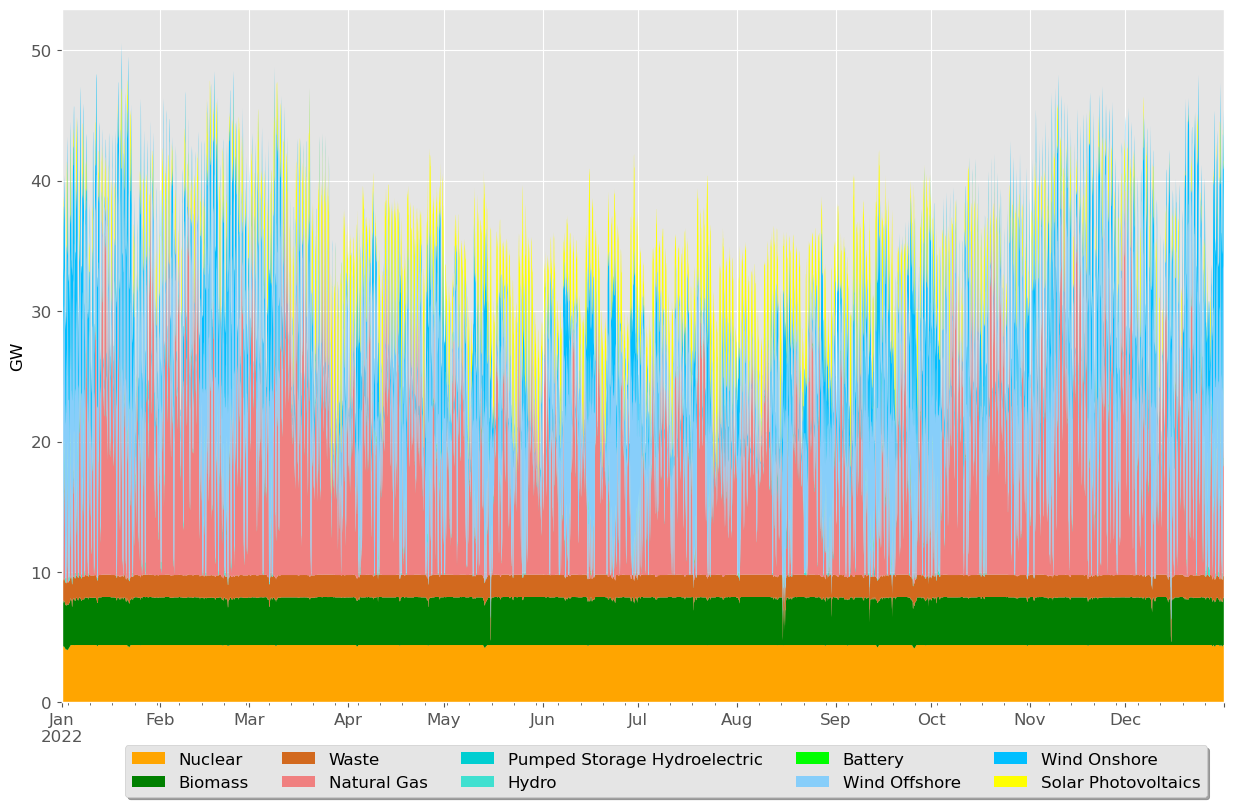

In [35]:
#cols = ["Nuclear", 'Biomass',
        #'Waste', "Oil", "Natural Gas",
       # 'Hydrogen', 'CCS Gas', 'CCS Biomass',
        #"Pumped Storage Hydroelectric", 'Hydro',
        #'Battery', 'Compressed Air', 'Liquid Air',
        #"Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        #'Interconnectors Import', 'Unmet Load'
       # ]
# ignore the import/export since the the highvoltage links are disrgearded

cols = ["Nuclear", 'Biomass',
        'Waste', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
         'Unmet Load'
        ]




p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)

colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          'B6 import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "deeppink",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# # stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
# (interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# # rescale the y axis
# ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.52, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

## Plotting storage

Graph the pumped hydro dispatch and state of charge...

Text(0.5, 0, '')

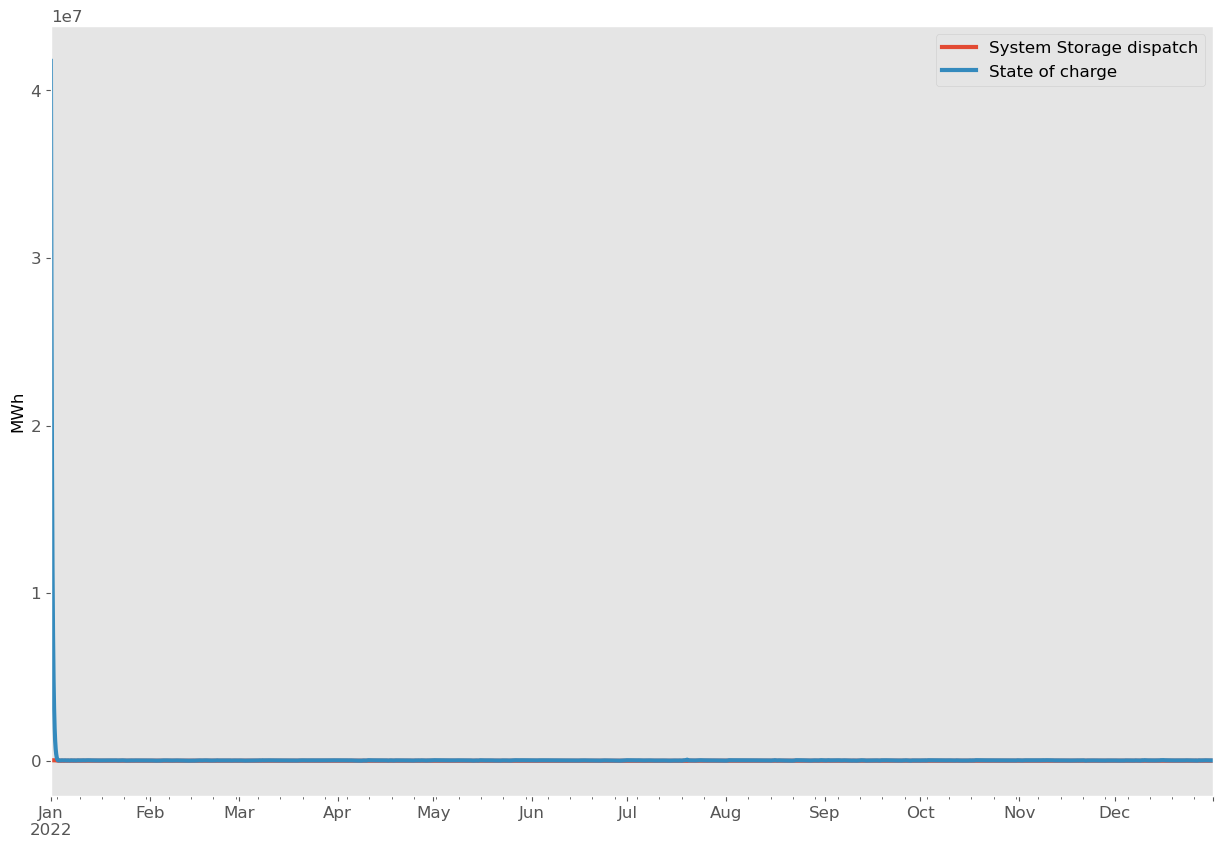

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage = network.storage_units_t.p.sum(axis=1)

state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1)
p_storage.plot(label="System Storage dispatch", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")

Let us plot the state of charge and dispatch for each type of storages separately

Text(0.5, 0, '')

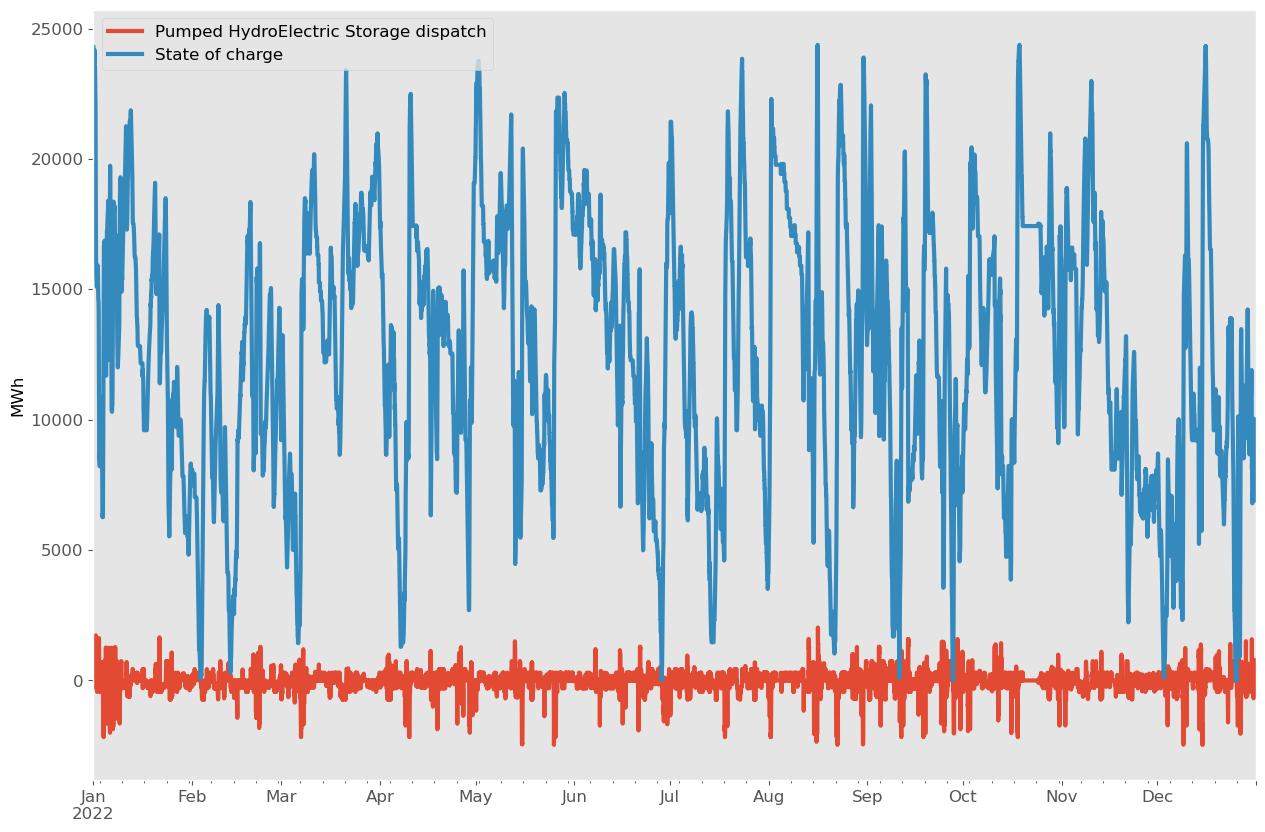

In [37]:
network.storage_units_t.state_of_charge.iloc[: , :4].sum(axis=1)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage_PumpedHydorES = network.storage_units_t.p.iloc[: , :4].sum(axis=1)

state_of_charge_PumpedHydroES = network.storage_units_t.state_of_charge.iloc[: , :4].sum(axis=1)


p_storage_PumpedHydorES.plot(label="Pumped HydroElectric Storage dispatch", ax=ax, linewidth=3)
state_of_charge_PumpedHydroES.plot(label="State of charge", ax=ax, linewidth=3)
ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")


Text(0.5, 0, '')

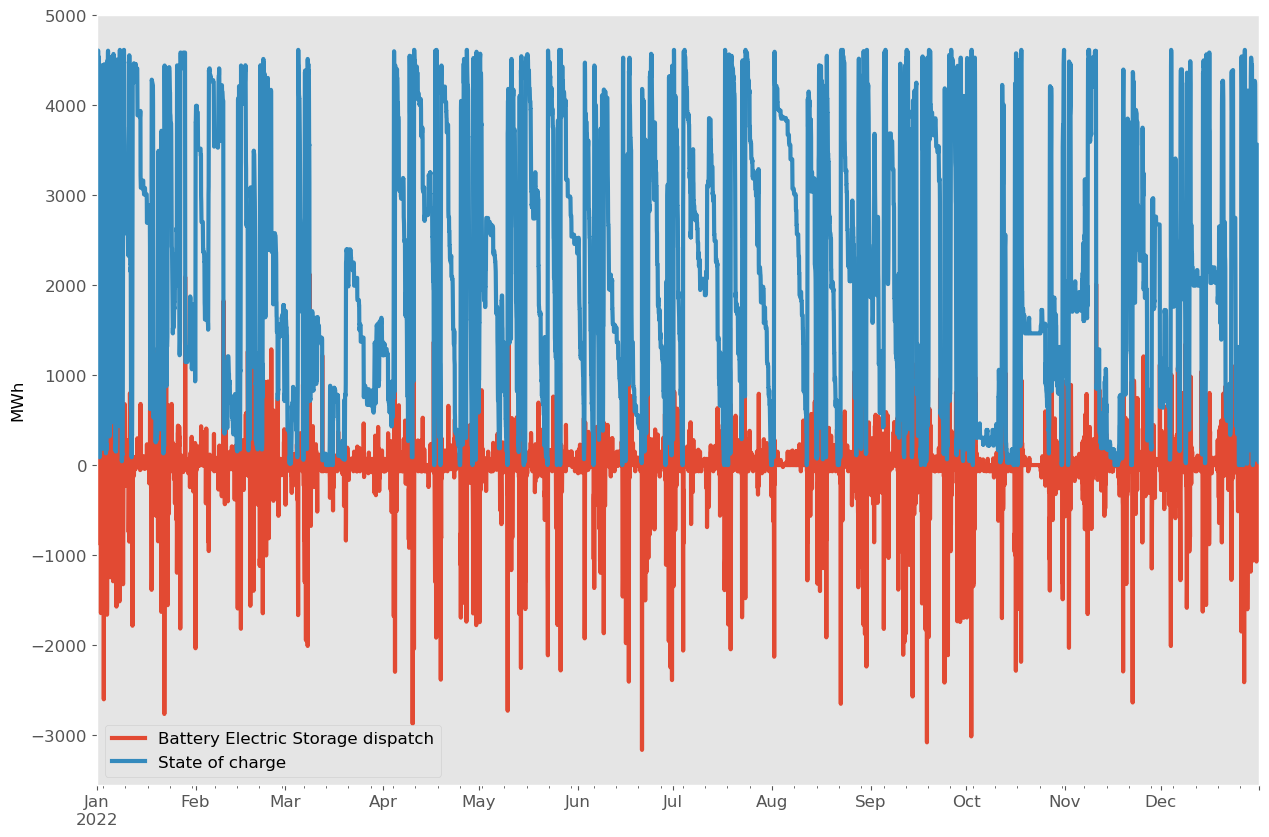

In [38]:
network.storage_units_t.state_of_charge.iloc[: , 4:33].sum(axis=1)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage_PumpedHydorES = network.storage_units_t.p.iloc[: , 4:33].sum(axis=1)

state_of_charge_PumpedHydroES = network.storage_units_t.state_of_charge.iloc[: , 4:33].sum(axis=1)


p_storage_PumpedHydorES.plot(label="Battery Electric Storage dispatch", ax=ax, linewidth=3)
state_of_charge_PumpedHydroES.plot(label="State of charge", ax=ax, linewidth=3)
ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")


Text(0.5, 0, '')

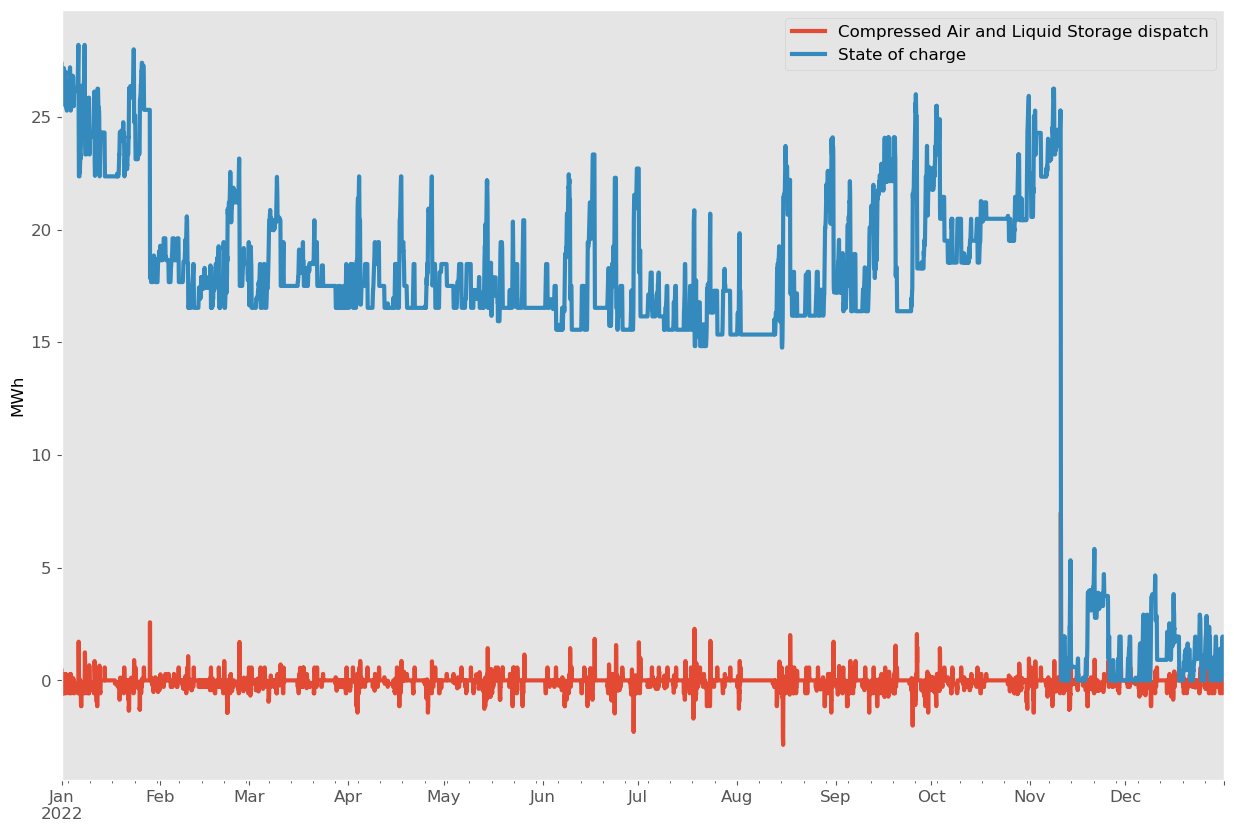

In [39]:
network.storage_units_t.state_of_charge.iloc[: , 33:91].sum(axis=1)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage_PumpedHydorES = network.storage_units_t.p.iloc[: , 33:91].sum(axis=1)

state_of_charge_PumpedHydroES = network.storage_units_t.state_of_charge.iloc[: , 33:91].sum(axis=1)


p_storage_PumpedHydorES.plot(label="Compressed Air and Liquid Storage dispatch", ax=ax, linewidth=3)
state_of_charge_PumpedHydroES.plot(label="State of charge", ax=ax, linewidth=3)
ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")


Text(0.5, 0, '')

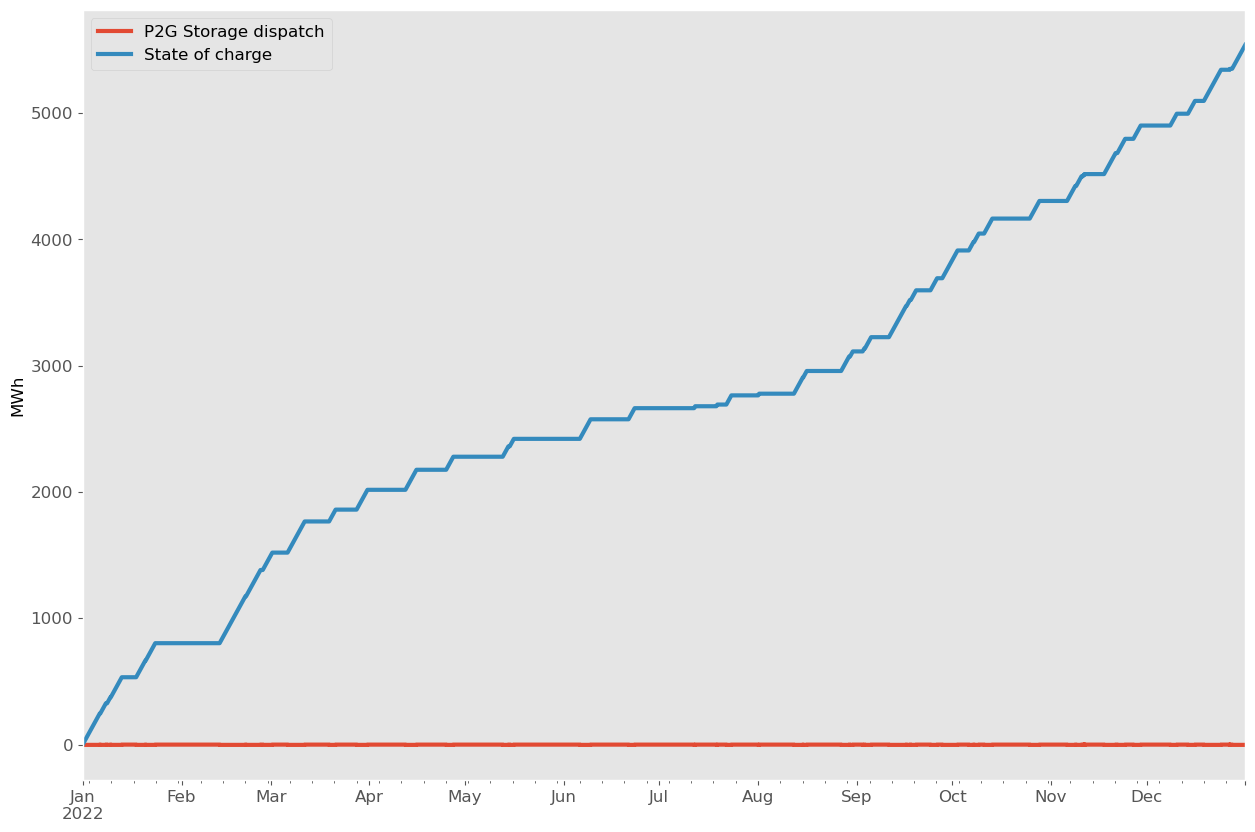

In [40]:
network.storage_units_t.state_of_charge.iloc[: , 91:120].sum(axis=1)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage_PumpedHydorES = network.storage_units_t.p.iloc[: , 91:120].sum(axis=1)

state_of_charge_PumpedHydroES = network.storage_units_t.state_of_charge.iloc[: , 91:120].sum(axis=1)


p_storage_PumpedHydorES.plot(label="P2G Storage dispatch", ax=ax, linewidth=3)
state_of_charge_PumpedHydroES.plot(label="State of charge", ax=ax, linewidth=3)
ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")


Text(0.5, 0, '')

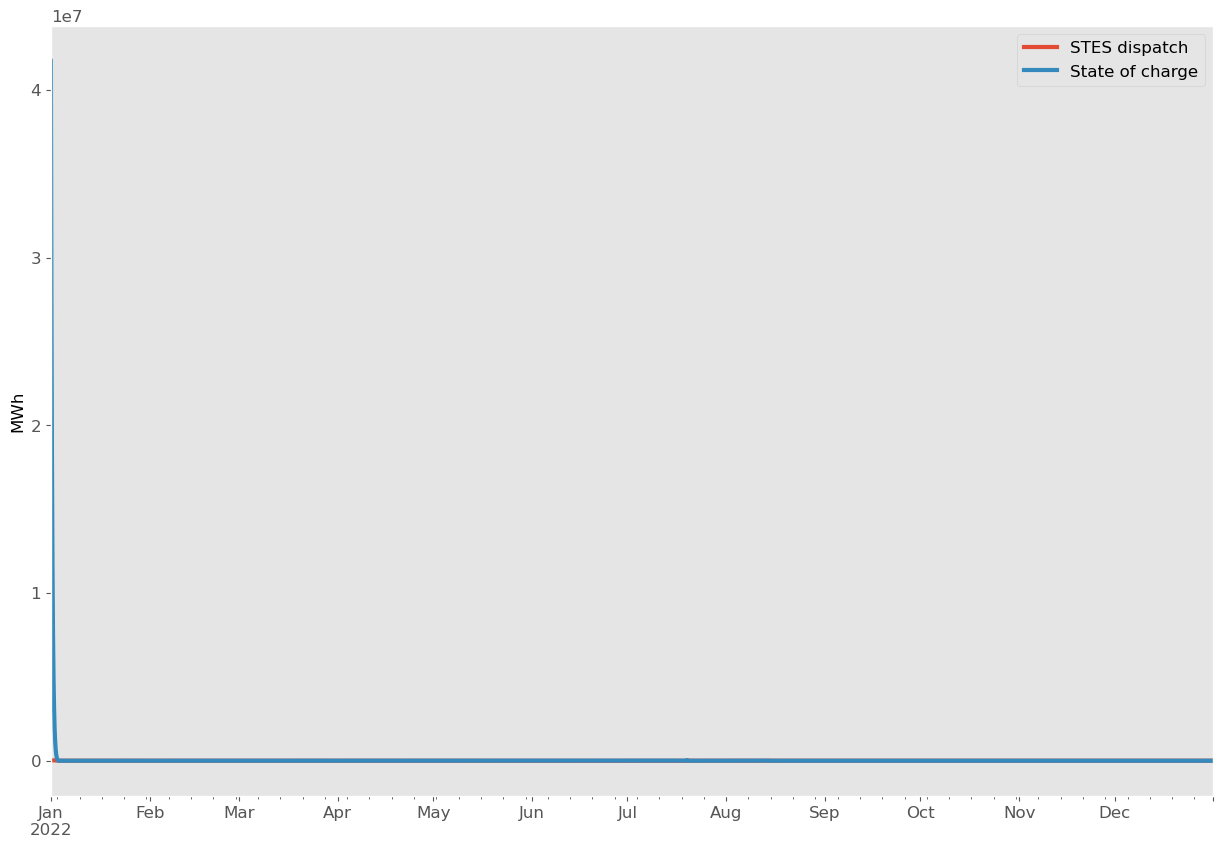

In [41]:
network.storage_units_t.state_of_charge.iloc[: , 120:150].sum(axis=1)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage_PumpedHydorES = network.storage_units_t.p.iloc[: , 120:150].sum(axis=1)

state_of_charge_PumpedHydroES = network.storage_units_t.state_of_charge.iloc[: , 120:150].sum(axis=1)


p_storage_PumpedHydorES.plot(label="STES dispatch", ax=ax, linewidth=3)
state_of_charge_PumpedHydroES.plot(label="State of charge", ax=ax, linewidth=3)
ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")


Let us add dditional constraint to the seasonal thermal energy storage and solve our model again with the conservative constraints included on Storages

For the sake of adding constraint to specific storage tehcnologies,better use the following information will help, https://docs.xarray.dev/en/stable/user-guide/indexing.html

In [42]:
sus=Linopy_model.variables['StorageUnit-state_of_charge']    # how to apply this for STES only?
Linopy_model.add_constraints(sus.loc[:, network.storage_units_t.p.iloc[: , 120:150].columns.tolist()]>=10000,name='StorageUnit_minimum_soc')   #let us add a 1000 MWh minimum state of charge for the STES at Beauly

C:\Users\salene\Anaconda3\envs\PyPSA-GB\lib\site-packages\linopy\model.py:607: UserWarning: Reindexing constraint `StorageUnit_minimum_soc` to match existing coordinates.
  warnings.warn(


Constraint `StorageUnit_minimum_soc` (snapshot: 8760, StorageUnit: 149) - 1051200 masked entries
------------------------------------------------------------------------------------------------
[2022-01-01 00:00:00, STES_Beauly]:           1.0 StorageUnit-state_of_charge[2022-01-01 00:00:00, STES_Beauly]           >= 10000
[2022-01-01 00:00:00, STES_Peterhead]:        1.0 StorageUnit-state_of_charge[2022-01-01 00:00:00, STES_Peterhead]        >= 10000
[2022-01-01 00:00:00, STES_Errochty]:         1.0 StorageUnit-state_of_charge[2022-01-01 00:00:00, STES_Errochty]         >= 10000
[2022-01-01 00:00:00, STES_Denny/BonnyBdige]: 1.0 StorageUnit-state_of_charge[2022-01-01 00:00:00, STES_Denny/BonnyBdige] >= 10000
[2022-01-01 00:00:00, STES_Neilston]:         1.0 StorageUnit-state_of_charge[2022-01-01 00:00:00, STES_Neilston]         >= 10000
[2022-01-01 00:00:00, STES_Strathaven]:       1.0 StorageUnit-state_of_charge[2022-01-01 00:00:00, STES_Strathaven]       >= 10000
[2022-01-01 00:00:00

In [43]:
network.generators.loc[network.generators.carrier == "heat", "p_nom_extendable"] = True     # let us make the boiler extendable

In [44]:
#Linopy_model.add_constraints(sus.loc[:, ['STES_Beauly','STES_Peterhead']]>=1000,name='StorageUnit_minimum_soc') 

In [45]:
#Linopy_model.add_constraints(sus>=200,name='StorageUnit_minimum_soc')

In [46]:
#sus=Linopy_model.variables['StorageUnit-state_of_charge']      # how to apply this for STES only?
#Linopy_model.add_constraints(sus>=200,name='StorageUnit_minimum_soc')

In [47]:
# then solve the model
network.model.constraints.remove("Kirchhoff-Voltage-Law")      # Let us remove the Kirchoff Voltage Law constraint
network.optimize.solve_model(solver_name='gurobi')

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


Read LP format model from file C:\Users\salene\AppData\Local\Temp\linopy-problem-oj0wgg5k.lp
Reading time = 68.67 seconds
obj: 28074934 rows, 9084179 columns, 50000083 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 28074934 rows, 9084179 columns and 50000083 nonzeros
Model fingerprint: 0x0f15ee74
Coefficient statistics:
  Matrix range     [7e-01, 3e+03]
  Objective range  [1e+00, 1e+09]
  Bounds range     [1e+07, 1e+07]
  RHS range        [2e-07, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 25376868 rows and 1102493 columns (presolve time = 5s) ...
Presolve removed 25376868 rows and 1116347 columns (presolve time = 11s) ...
Presolve removed 25376868 rows and 1116347 columns (presolve tim

  84   1.09907140e+11  1.09845406e+11  1.28e-06 3.60e-07  5.27e+00   530s
  85   1.09905585e+11  1.09846274e+11  1.90e-06 4.08e-07  5.06e+00   534s
  86   1.09902922e+11  1.09847745e+11  1.79e-06 4.38e-07  4.71e+00   540s
  87   1.09901198e+11  1.09849333e+11  1.63e-06 4.48e-07  4.43e+00   546s
  88   1.09898945e+11  1.09850377e+11  1.38e-06 4.18e-07  4.14e+00   552s
  89   1.09897428e+11  1.09851517e+11  1.62e-06 3.68e-07  3.92e+00   559s
  90   1.09895245e+11  1.09852117e+11  1.71e-06 3.93e-07  3.68e+00   565s
  91   1.09893619e+11  1.09854009e+11  1.64e-06 3.57e-07  3.38e+00   572s
  92   1.09891890e+11  1.09855404e+11  1.49e-06 3.47e-07  3.11e+00   578s
  93   1.09890650e+11  1.09856519e+11  1.45e-06 3.59e-07  2.91e+00   584s
  94   1.09888787e+11  1.09856970e+11  1.95e-06 3.78e-07  2.72e+00   591s
  95   1.09887601e+11  1.09858194e+11  1.84e-06 3.55e-07  2.51e+00   598s
  96   1.09886755e+11  1.09858759e+11  2.06e-06 3.92e-07  2.39e+00   604s
  97   1.09886378e+11  1.09859595e+11 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 9084179 primals, 28074934 duals
Objective: 1.10e+11
Solver model: available
Solver message: 2



('ok', 'optimal')

In [48]:
network.storage_units_t.state_of_charge.iloc[: , 120:150]

StorageUnit,STES_Beauly,STES_Peterhead,STES_Errochty,STES_Denny/BonnyBdige,STES_Neilston,STES_Strathaven,STES_Torness,STES_Eccles,STES_Harker,STES_Stella West,...,STES_Bramford,STES_Pelham,STES_Sundon_East_Claydon,STES_Melksham,STES_Bramley,STES_London,STES_Kemsley,STES_Sellindge,STES_Lovedean,STES_S_W_Penisula
snapshot,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,1.439513e+06,1.440457e+06,1.439623e+06,1.439474e+06,1.439474e+06,1.439474e+06,1.439474e+06,1.439474e+06,1.439474e+06,1.439474e+06,...,1.438675e+06,1.438832e+06,1.437174e+06,1.438934e+06,1.439474e+06,1.437445e+06,1.439474e+06,1.439474e+06,1.439474e+06,1.439474e+06
2022-01-01 01:00:00,1.295346e+06,1.296946e+06,1.295310e+06,1.295000e+06,1.295000e+06,1.295000e+06,1.295000e+06,1.295000e+06,1.295000e+06,1.295000e+06,...,1.293483e+06,1.293781e+06,1.290631e+06,1.293975e+06,1.295000e+06,1.291145e+06,1.295000e+06,1.295000e+06,1.295000e+06,1.295000e+06
2022-01-01 02:00:00,1.165595e+06,1.167784e+06,1.165465e+06,1.164974e+06,1.164974e+06,1.164974e+06,1.164974e+06,1.164974e+06,1.164974e+06,1.164974e+06,...,1.162810e+06,1.163235e+06,1.158743e+06,1.163512e+06,1.164974e+06,1.159476e+06,1.164974e+06,1.164974e+06,1.164974e+06,1.164974e+06
2022-01-01 03:00:00,1.048799e+06,1.051432e+06,1.048545e+06,1.047951e+06,1.047951e+06,1.047951e+06,1.047951e+06,1.047951e+06,1.047951e+06,1.047951e+06,...,1.045204e+06,1.045744e+06,1.040043e+06,1.046095e+06,1.047951e+06,1.040973e+06,1.047951e+06,1.047951e+06,1.047951e+06,1.047951e+06
2022-01-01 04:00:00,9.433933e+05,9.462311e+05,9.433173e+05,9.426295e+05,9.426295e+05,9.426295e+05,9.426295e+05,9.426295e+05,9.426295e+05,9.426295e+05,...,9.393592e+05,9.400016e+05,9.332129e+05,9.404192e+05,9.426295e+05,9.343204e+05,9.426295e+05,9.426295e+05,9.426295e+05,9.426295e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2022-12-31 20:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2022-12-31 21:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


Text(0.5, 0, '')

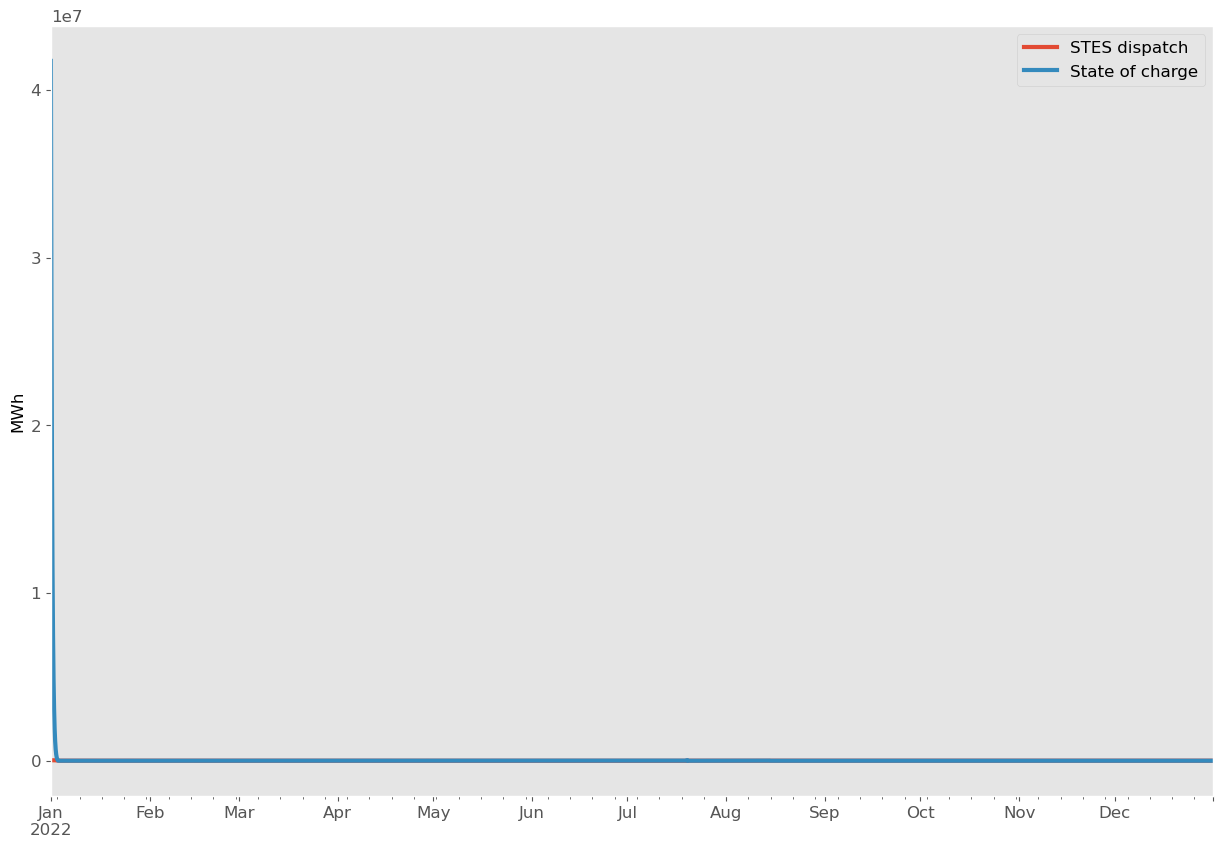

In [49]:
network.storage_units_t.state_of_charge.iloc[: , 120:150].sum(axis=1)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage_PumpedHydorES = network.storage_units_t.p.iloc[: , 120:150].sum(axis=1)

state_of_charge_PumpedHydroES = network.storage_units_t.state_of_charge.iloc[: , 120:150].sum(axis=1)


p_storage_PumpedHydorES.plot(label="STES dispatch", ax=ax, linewidth=3)
state_of_charge_PumpedHydroES.plot(label="State of charge", ax=ax, linewidth=3)
ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")


## Plotting line loading

Look at the line loading stats and graph...

In [50]:
now = network.snapshots[60]

print("With the linear load flow, there is the following per unit loading:")
loading = network.lines_t.p0.loc[now] / network.lines.s_nom
loading.describe()

With the linear load flow, there is the following per unit loading:


count    99.000000
mean      0.009322
std       0.637003
min      -0.700000
25%      -0.700000
50%       0.144555
75%       0.700000
max       0.700000
dtype: float64

(<matplotlib.collections.PatchCollection at 0x1df851143a0>,
 <matplotlib.collections.LineCollection at 0x1df85168ca0>)

C:\Users\salene\Anaconda3\envs\PyPSA-GB\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


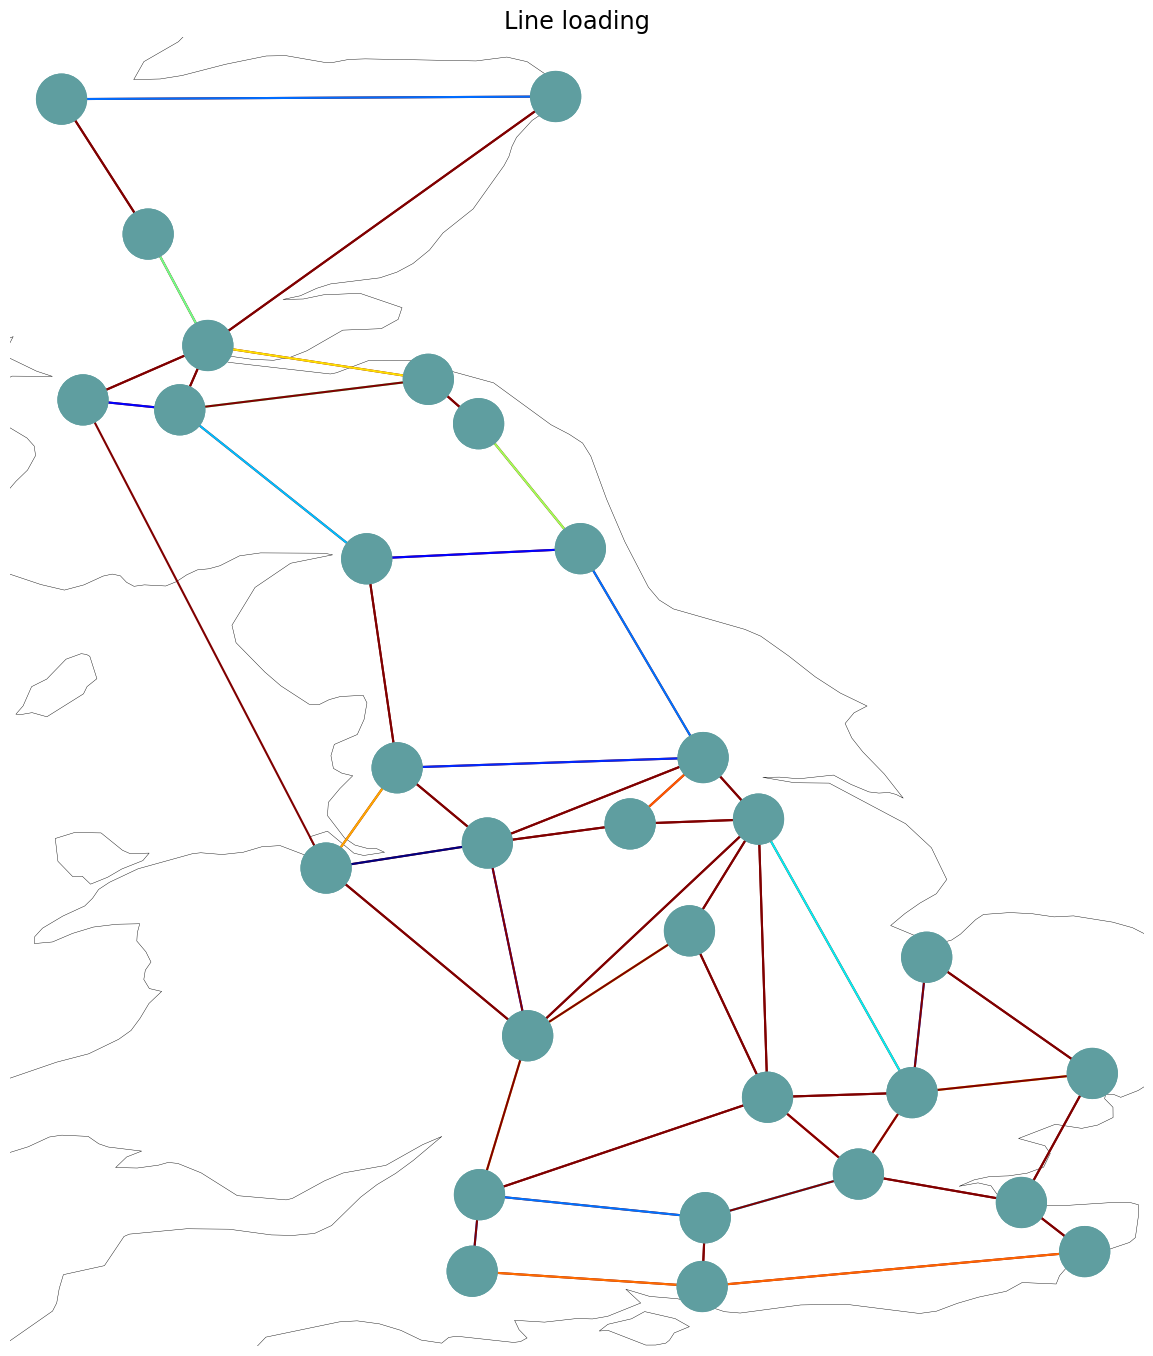

In [51]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(15, 17)

network.plot(ax=ax, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading")

## Plotting locational marginal prices

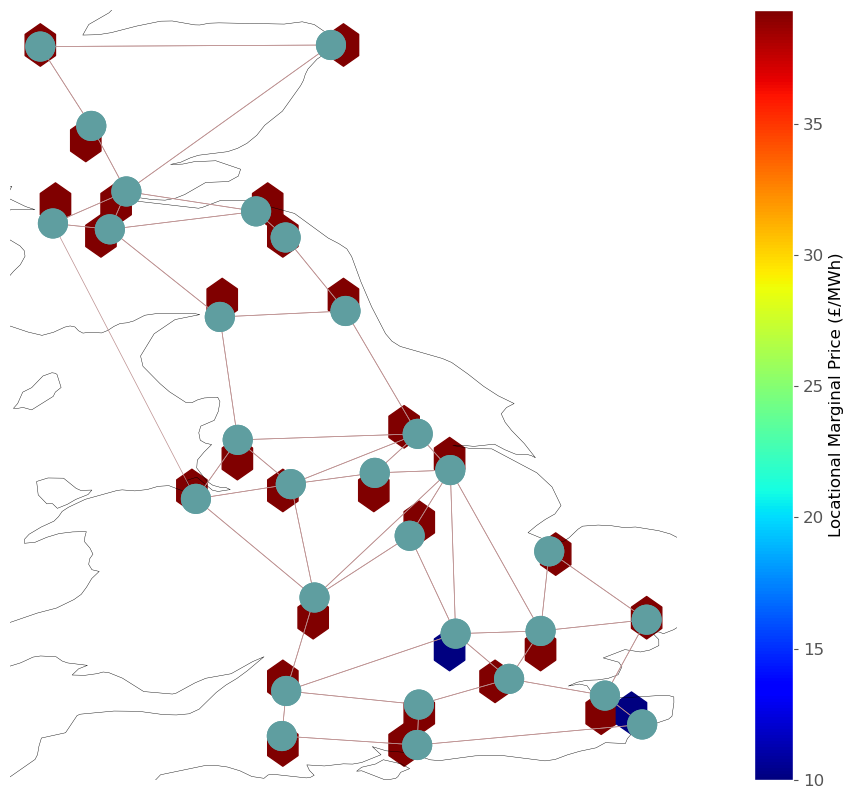

In [52]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_widths=pd.Series(0.5, network.lines.index))
plt.hexbin(network.buses.x, network.buses.y,
           gridsize=20,
           C=network.buses_t.marginal_price.loc[now],
           cmap=plt.cm.jet)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Locational Marginal Price (£/MWh)')

In [53]:
network.buses_t.marginal_price

,Eccles,Errochty,Heat Bus 1,Heat Bus 10,Heat Bus 11,Heat Bus 12,Heat Bus 13,Heat Bus 14,Heat Bus 15,Heat Bus 16,...,Th. Marsh/Stocksbridge,Bramford,Beauly,Penwortham,Denny/Bonnybridge,Neilston,Pelham,Peterhead,Harker,Bramley
snapshot,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,54.920000,54.920000,-0.080887,20.0,20.000000,19.869754,19.934664,20.0,20.0,20.0,...,54.920000,54.920000,0.0,54.920000,54.920000,54.920000,54.920000,0.0,54.920000,54.920000
2022-01-01 01:00:00,54.740000,54.740000,0.060865,20.0,20.000000,20.000000,19.869328,20.0,20.0,20.0,...,54.740000,54.740000,0.0,54.740000,54.740000,54.740000,54.740000,0.0,54.740000,54.740000
2022-01-01 02:00:00,54.470000,54.470000,0.067628,20.0,20.000000,20.000000,19.771325,20.0,20.0,20.0,...,54.470000,54.470000,0.0,54.470000,54.470000,54.470000,54.470000,0.0,54.470000,54.470000
2022-01-01 03:00:00,54.200000,54.200000,0.075142,20.0,19.868035,19.482387,19.673321,20.0,20.0,20.0,...,54.200000,54.200000,0.0,54.200000,54.200000,54.200000,54.200000,0.0,54.200000,54.200000
2022-01-01 04:00:00,54.290000,54.290000,20.000000,20.0,20.000000,19.514738,19.705989,20.0,20.0,20.0,...,54.290000,54.290000,0.0,54.290000,54.290000,54.290000,54.290000,0.0,54.290000,54.290000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,70.826725,70.272979,20.000000,20.0,20.000000,20.000000,20.000000,20.0,20.0,20.0,...,70.826725,70.826725,0.0,70.826725,70.826725,70.826725,70.826725,0.0,70.826725,70.826725
2022-12-31 20:00:00,70.826725,70.272979,20.000000,20.0,20.000000,20.000000,20.000000,20.0,20.0,20.0,...,70.826725,70.826725,0.0,70.826725,70.826725,70.826725,70.826725,0.0,70.826725,70.826725
2022-12-31 21:00:00,70.826725,70.272979,20.000000,20.0,20.000000,20.000000,20.000000,20.0,20.0,20.0,...,70.826725,70.826725,0.0,70.826725,70.826725,70.826725,70.826725,0.0,70.826725,70.826725


## Plotting curtailment

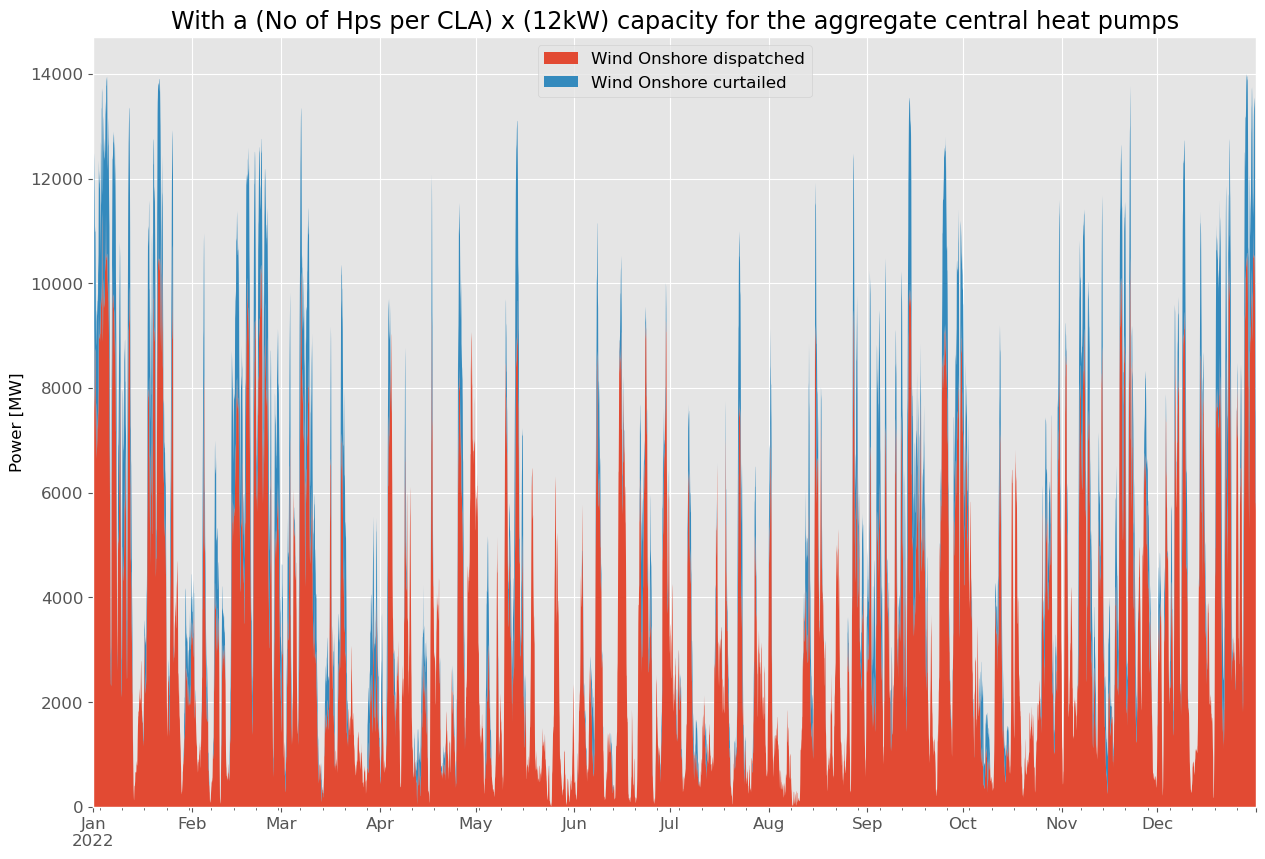

In [54]:
carrier = "Wind Onshore"

capacity = network.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = network.generators_t.p_max_pu.multiply(network.generators["p_nom"])
p_available_by_carrier = p_available.groupby(network.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier
p_df = pd.DataFrame({carrier + " available": p_available_by_carrier[carrier],
                     carrier + " dispatched": p_by_carrier[carrier],
                     carrier + " curtailed": p_curtailed_by_carrier[carrier]})

p_df[carrier + " capacity"] = capacity
p_df["Wind Onshore curtailed"][p_df["Wind Onshore curtailed"] < 0.] = 0.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(kind="area", ax=ax, linewidth=0)
# p_df[[carrier + " available", carrier + " capacity"]].plot(ax=ax, linewidth=0)

ax.set_xlabel("")
ax.set_title("With a (No of Hps per CLA) x (12kW) capacity for the aggregate central heat pumps")
ax.set_ylabel("Power [MW]")
ax.legend()

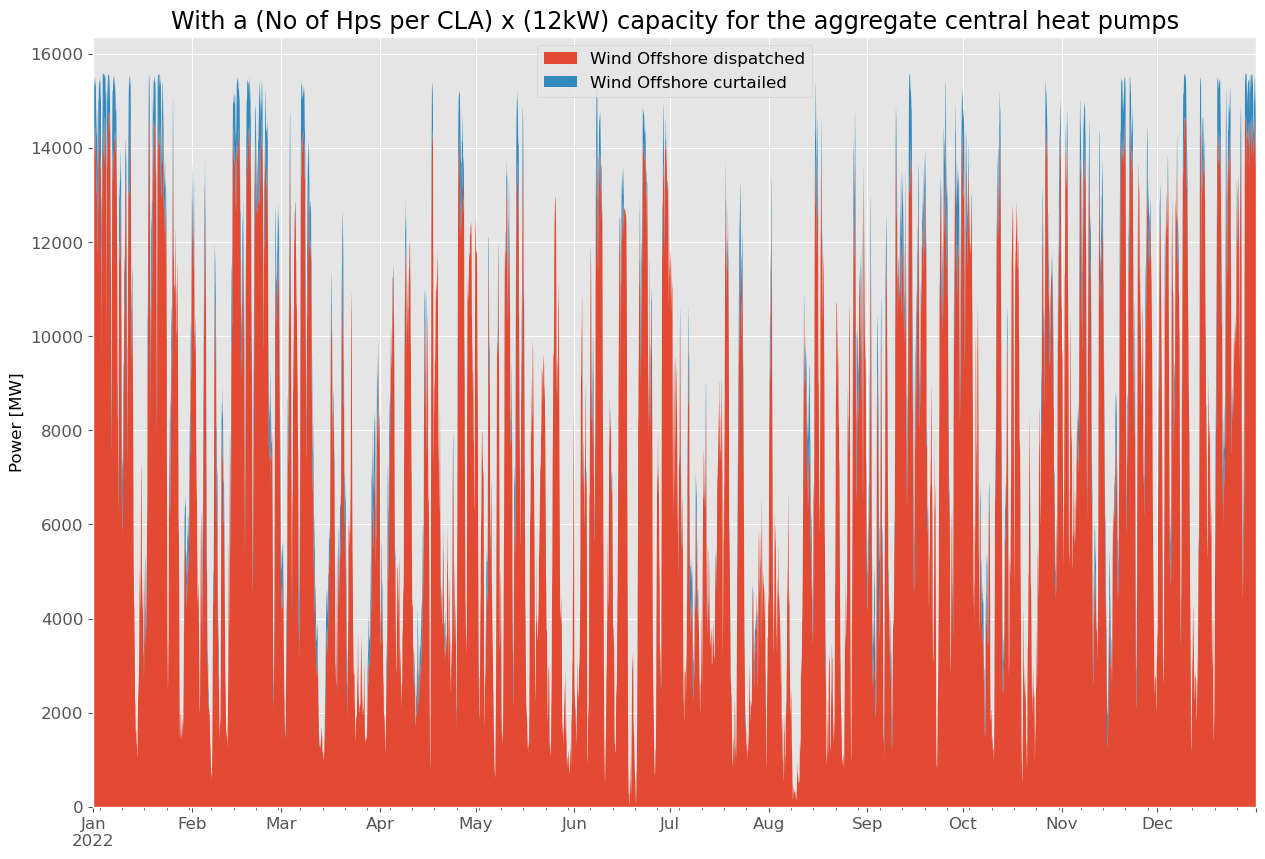

In [55]:
carrier = "Wind Offshore"

capacity = network.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = network.generators_t.p_max_pu.multiply(network.generators["p_nom"])
p_available_by_carrier = p_available.groupby(network.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier
p_df = pd.DataFrame({carrier + " available": p_available_by_carrier[carrier],
                     carrier + " dispatched": p_by_carrier[carrier],
                     carrier + " curtailed": p_curtailed_by_carrier[carrier]})

p_df[carrier + " capacity"] = capacity
p_df["Wind Offshore curtailed"][p_df["Wind Offshore curtailed"] < 0.] = 0.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(kind="area", ax=ax, linewidth=0)
# p_df[[carrier + " available", carrier + " capacity"]].plot(ax=ax, linewidth=0)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.set_title("With a (No of Hps per CLA) x (12kW) capacity for the aggregate central heat pumps")
ax.legend()

In [56]:
# Stop the timer and calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Elapsed time: 61721.82473874092 seconds
